In [1]:
import requests
import os 
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint 
import pytz
import schedule
import time
from PIL import Image
from IPython.display import display
pd.options.mode.chained_assignment = None 
import re


# goal_counts_df = 'C:\\Users\\Karoline Sears\\Documconcatents\\GitHub\\hockey-streamlit\\data\\goal_counts.csv'
# goal_counts_df = pd.read_csv(goal_counts_df)
# goal_location_df = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_locations.csv'
# goal_location_df= pd.read_csv(goal_location_df)
formatted_date = "2024-04-09"
base_url = "https://api-web.nhle.com/v1/schedule/"
api_url = f"{base_url}{formatted_date}"
#api_url = "https://api-web.nhle.com/v1/schedule/2023-10-11"
response = requests.get(api_url )
content = json.loads(response.content)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    #pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)

#get the dates and game numbers for the season
game_dates = json_data['gameWeek']

#convert the game info dictionary into a dataframe
df_game_info= pd.DataFrame(game_dates)
df_game_info = df_game_info.convert_dtypes()
#df_game_info.head()

#Normalize (separates the data in the curly brackets out into separate columns)
game_data =pd.json_normalize(df_game_info['games'])
game_data= pd.DataFrame(game_data)
#game_data.head()
#end_value = len(game_data.columns)



In [2]:
dfs = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_data.columns)): 
    api_response = game_dates
    
    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_data[i])
        
        # Create a DataFrame for this iteration
        df_name = f'game_test{i}'  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")



In [3]:
#Then I combine all of the dfs in the list by concatenation to create a single df
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df = combined_df[['id', 'season', 'startTimeUTC', 'gameType', 'awayTeam.placeName.default', 'awayTeam.id', 'awayTeam.abbrev', 'awayTeam.logo', 
                           'homeTeam.placeName.default', 'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo', 'awayTeam.score', 'homeTeam.score', 'winningGoalScorer.playerId', 
                        'winningGoalie.playerId', 'gameState']]
combined_df=combined_df.convert_dtypes()
combined_df['id'] = combined_df['id'].astype(str)
combined_df['link_prefix'] = 'https://api-web.nhle.com/v1/gamecenter/'
combined_df['link_suffix'] = '/play-by-play'
combined_df['link']=combined_df['link_prefix'] + combined_df['id'] + combined_df['link_suffix']

# Assuming '<NA>' is a string, replace it with np.nan
# combined_df['game_id'].replace('<NA>', np.nan, inplace=True)
# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=['id'])
combined_df = combined_df.query('gameState == "OFF"')
combined_df['startTimeUTC'] = pd.to_datetime(combined_df['startTimeUTC'])


# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone('America/New_York')

# Convert 'startTimeUTC' to Eastern Time
combined_df['game_date'] = combined_df['startTimeUTC'].dt.tz_convert(eastern_timezone)
combined_df['game_date'] = pd.to_datetime(combined_df['game_date'])
combined_df['game_date'] = combined_df['game_date'].dt.strftime('%Y-%m-%d')
combined_df.drop('startTimeUTC', axis=1, inplace=True)
# combined_df = combined_df[combined_df['game_date'] == formatted_date]
#combined_df.head()
print("combined_df done")


combined_df done


In [4]:

# #Roster Data
home_df = pd.DataFrame({
    'team_id': combined_df['homeTeam.id'],
    'tri_code': combined_df['homeTeam.abbrev'],
    'team_name': combined_df['homeTeam.placeName.default'],
    'value': "home"
})

away_df =  pd.DataFrame({
    'team_id': combined_df['awayTeam.id'],
    'tri_code': combined_df['awayTeam.abbrev'],
    'team_name': combined_df['awayTeam.placeName.default'],
    'value':"away"
})
                         
# Concatenate the two DataFrames vertically
teams_df = pd.concat([home_df, away_df], ignore_index=True)

teams_df['prefix'] = "https://api-web.nhle.com/v1/roster/"
teams_df['suffix'] = "/20232024"
teams_df['roster_url'] = teams_df['prefix'] + teams_df['tri_code'] + teams_df['suffix']
teams_df = teams_df.sort_values(by='team_id')

# Create an empty dictionary to store the results
# Create an empty dictionary to store the results
roster_dict = {}

# Loop through the rows of the 'teams_df' DataFrame
for index, row in teams_df.iterrows():
    try:
        # Send an HTTP GET request to the roster URL
        response = requests.get(row['roster_url'])
        
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            json_data = json.loads(response.text)

            # Extract player information
            players_data = json_data['forwards'] + json_data['defensemen'] + json_data['goalies']

            # Extract tricode using list comprehension
            roster_data = [
                {
                    'tri_code': re.search(r'/([A-Z]{3})/', player['headshot']).group(1),
                    'player_id': player['id'],
                    'headshot': player['headshot'],
                    'player_name': f"{player['firstName']['default']} {player['lastName']['default']}",
                    'sweaterNumber': player['sweaterNumber'],
                    'positionCode': player['positionCode'],
                    # add other player information...
                }
                for player in players_data
            ]

            # Create DataFrame directly from the list of dictionaries
            team_roster_df = pd.DataFrame(roster_data)

            # Add a 'team_id' column to the DataFrame
            team_roster_df['team_id'] = row['team_id']

            # Store the result in the dictionary with the team ID as the key
            roster_dict[row['team_id']] = team_roster_df

        else:
            print(f"Request failed for {row['roster_url']} with status code {response.status_code}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Concatenate all team rosters into a single DataFrame
all_rosters = pd.concat(roster_dict.values(), ignore_index=True)

# Merge team rosters with 'teams_df' based on 'team_id'
team_rosters = teams_df[['team_id', 'tri_code', 'team_name']]
team_rosters = team_rosters.merge(all_rosters, on="team_id", how="left")
team_rosters = team_rosters.rename(columns={'id': 'player_id'})


print("rosters done")

games = combined_df[['id', 'season', 'gameType', 'awayTeam.id', 'awayTeam.abbrev', 'awayTeam.logo', 
                        'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo', 'awayTeam.score', 'homeTeam.score', 'winningGoalScorer.playerId', 
                        'winningGoalie.playerId', 'link']]
games = games.sort_values(by='id')
games = games.rename(columns = {'id':'game_id', 'gameType':'game_type', 'awayTeam.id':'away_team_id', 'awayTeam.abbrev':'away_team_tricode', 
                    'awayTeam.logo': 'away_logo', 'homeTeam.id':'home_team_id', 'homeTeam.abbrev':'home_team_tricode', 'homeTeam.logo':'home_logo', 
                    'awayTeam.score': 'away_score', 'homeTeam.score':'home_score', 'winningGoalScorer.playerId':'winning_goal_player_id', 
                    'winningGoalie.playerId':'winning_goalie_id'})

# Merge DataFrames based on home_team_code
games = pd.merge(games, team_rosters, left_on='home_team_id', right_on='team_id', how='left')

# Rename columns for home team
games.rename(columns={'roster_url': 'home_roster_link', 'team_name': 'home_team_name'}, inplace=True)

# Merge DataFrames based on away_team_code
games = pd.merge(games, team_rosters, left_on='away_team_id', right_on='team_id', how='left')

# Rename columns for away team
games.rename(columns={'roster_url': 'away_roster_link', 'team_name': 'away_team_name'}, inplace=True)

# Drop redundant columns
games.drop(columns=['home_team_id', 'away_team_id'], inplace=True)

print("games merged")


An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: 'sweaterNumber'
An error occurred: '

In [9]:

# Create an empty dictionary to store the results
for index, row in games.iterrows():
    # Check if 'link' is in the columns of the current row
    if 'link' not in row.index:
        print(f"Skipping row {index} as it does not contain 'link' column.")
        continue

game_link = row['link']
game_data_dict = {}
game_id = row['game_id']

# Define your extraction script as a function
def extract_game_data(game_link, game_id):
    try:
        # Send an HTTP GET request to the game URL
        response = requests.get(game_link)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            response_text = response.text
            json_game_data = json.loads(response_text)

            # Event data
            event_data = json_game_data['plays']
            events_df = pd.DataFrame(event_data)
            events_df = events_df.convert_dtypes()
           
            # Game events data
            game_events = events_df[['sortOrder', 'timeInPeriod', 'homeTeamDefendingSide', 'typeCode']]

            # Coordinates data
            details = pd.json_normalize(events_df['details'])
            details = pd.DataFrame(details)
            details = details[['eventOwnerTeamId', 'xCoord', 'yCoord', 'shotType', 'scoringPlayerId']]

            # Join the dataframes
            all_game_data = game_events.merge(details, left_index=True, right_index=True)

            # Filter rows where 'typeCode' is 505-508
            shots = all_game_data[all_game_data['typeCode'].isin([505, 506, 507, 508])]

            # Create a 'game_id' column
           # shots['game_id'] = game_id
           # print(f"game id done {game_id}")

            return shots  # Return the processed DataFrame and game_id

        else:
            print(f"Request failed for {game_link} with status code {response.status_code}")
            return pd.DataFrame()  # Return an empty DataFrame to indicate failure


    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(), None  # Return an empty DataFrame and None to indicate failure

all_game_data


NameError: name 'all_game_data' is not defined

In [ ]:
# Create an empty dictionary to store the results
game_data_dict = {}

# Iterate through games DataFrame
for index, row in games.iterrows():
    # Extract the API link and game ID from the current row
    game_link, game_id = row['link'], row['game_id']

    # Check if 'link' is in the columns of the current row
    if 'link' not in row.index:
        print(f"Skipping row {index} as it does not contain 'link' column.")
        continue

    game_link = row['link']
    game_data_dict = {}
    game_id = row['game_id']

    # Run your game-specific data script and get the entire processed DataFrame
    game_specific_data = extract_game_data(game_link, game_id)

    # Add a 'game_id' column to the game_specific_data DataFrame
    game_specific_data['game_id'] = game_id

    # Store the result in the dictionary with the game ID as the key
    game_data_dict[game_id] = game_specific_data
  #  print("dictionary done")
    
    
    # Access the shots DataFrame directly
    
    shots_df = game_specific_data[game_specific_data['typeCode'].isin([505, 506, 507, 508])]
    shots_df = shots_df.sort_values(by=[ 'timeInPeriod', 'sortOrder'])

    shots_df=shots_df.rename(columns = {'eventOwnerTeamId':'team_id'})
    shots_df['team_id'] =shots_df['team_id'].astype('Int64').astype(int)
    
    game_goals_data = shots_df[shots_df['typeCode'] == 505]
    game_goals_data = game_goals_data.rename(columns = {'scoringPlayerId':'player_id'})
    team_rosters = team_rosters.rename(columns = {'sweaterNumber': 'jersey_number', 'positionCode':'position'})

print("goals done")

# #Merging game data and roster data to create goal counts
# if 'player_id' in team_rosters.columns:
#     # Merge the coordinates data from final_game_data to goal_counts based on player IDs
#     goal_counts = team_rosters.merge(game_goals_data[['player_id', 'sortOrder']],on = 'player_id')
# else:
#     print("Column 'player_id 'does not exist in goal_counts DataFrame.")

# goal_counts = goal_counts.groupby(['jersey_number','player_id', 'player_name', 'position', 'team_name'])['sortOrder'].count()
# goal_counts=pd.DataFrame(goal_counts).reset_index()
# goal_counts = goal_counts.rename(columns={'sortOrder': 'goals'})
# goal_counts = goal_counts.sort_values(by='player_name')
# print("goal counts done")

# if 'player_id' in team_rosters.columns:
#     # Merge the coordinates data from final_game_data to goal_counts based on player IDs
#     goal_locations = team_rosters.merge(game_goals_data[['player_id', 'sortOrder', 'xCoord','yCoord', 'game_id']],on = 'player_id')
# else:
#     print("Column 'player_id 'does not exist in goal_counts DataFrame.")

# goal_locations = goal_locations[['jersey_number', 'player_id','player_name', 'position', 'team_name', 'sortOrder',  'xCoord', 'yCoord', 'game_id']]
# goal_locations = goal_locations.dropna(subset=['player_id'])
# goal_locations = goal_locations.sort_values(['player_name', 'player_id', 'sortOrder'], ascending=[True, True, True])
# print("goal locations done")
# #append the data to the master set
# goal_location_df = pd.concat([goal_location_df, goal_locations], ignore_index=True)
# goal_location_df =  goal_location_df.sort_values(['player_name', 'player_id', 'sortOrder'], ascending=[True, True, True])

# # Append last_nights_goals to season_goals
# combined_goals = pd.concat([goal_counts_df, goal_counts], ignore_index=True)

# # Sum up the goals for duplicated players
# result = combined_goals.groupby(['jersey_number', 'player_id', 'player_name', 'position', 'team_name'], as_index=False)['goals'].sum()
# result=result.sort_values(by='player_name')


# #running count of goal number for each player - make sure this is ordered by game id and time in period

# goal_talley =goal_location_df.sort_values(['player_name', 'player_id', 'game_id', 'sortOrder'], 
#                                           ascending=[True, True, True, True, True])
# goal_talley['goal_no'] = goal_talley.groupby('player_id').cumcount()+1

# def adjust_coordinates(row):
#     x = row['xCoord']
#     y = row['yCoord']
#     if x < 0:
#         adj_x = abs(x)
#         adj_y = -y
#     else:
#         adj_x = x
#         adj_y = y
#     return pd.Series({'x_adjusted': adj_x, 'y_adjusted': adj_y})

# # Apply the function to each row of the DataFrame
# goal_talley[['x_adjusted', 'y_adjusted']] = goal_talley.apply(adjust_coordinates, axis=1)
# ice_map_data = goal_talley
# ice_map_data=ice_map_data[['game_id', 'goal_no', 'player_id','player_name', 'team_name', 'period', 'x_adjusted', 'y_adjusted' ]]
# print("goal tally done")
# # file_path3 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\ice_map_data.csv'
# # ice_map_data.to_csv(file_path3,  index=False, encoding='utf-8')
# # print("completed", formatted_date)

In [ ]:
goal_locations.head()

In [ ]:
shots_df.head()

In [ ]:
game_shots_df = shots_df.merge(teams_df[['team_id', 'team_name']], on='team_id')
game_shots_df

In [ ]:
combined_df.head()

In [ ]:
final_shot_data = pd.concat(game_data_dict.values(), ignore_index=True)
final_shot_data['eventOwnerTeamId'] = final_shot_data['eventOwnerTeamId'].astype('Int64').astype(int)
final_shot_data = pd.merge(final_shot_data, teams_df[['team_id', 'team_name']], left_on='eventOwnerTeamId', right_on='team_id', how='left')
final_shot_data.head()

In [ ]:

home_df = pd.DataFrame({
    'team_id': combined_df['homeTeam.id'],
    'tri_code': combined_df['homeTeam.abbrev'],
    'team_name': combined_df['homeTeam.placeName.default'],
    'value': "home"
})

away_df =  pd.DataFrame({
    'team_id': combined_df['awayTeam.id'],
    'tri_code': combined_df['awayTeam.abbrev'],
    'team_name': combined_df['awayTeam.placeName.default'].
    'value':"away"
})
home_df                      

In [6]:


# Define a custom function to create the desired concatenated value
def create_matchup_date(row):
    home_team_id = row['homeTeam.placeName.default']
    away_team_id = row['awayTeam.placeName.default']
    
    # Look up the home and away team names from the 'logos' DataFrame
    home_team_name = combined_df.loc[combined_df['homeTeam.id'] == home_team_id, 'awayTeam.abbrev	'].values[0]
    away_team_name = combined_df.loc[combined_df['awayTeam.id'] == away_team_id, 'homeTeam.abbrev	'].values[0]
    
    game_date = row['game_date']
    return f"{home_team_name} vs {away_team_name}, {game_date}"

# Apply the custom function to create the new 'matchup_date' column
final_shot_data['matchup'] = final_shot_data.apply(create_matchup_date, axis=1)

# Now, the 'matchup_date' column contains the desired concatenated values
final_shot_data.head()

NameError: name 'final_shot_data' is not defined

In [ ]:
from hockey_rink import NHLRink, RinkImage


# Loop through periods
for period in [1, 2, 3]:  # Assuming you have three periods in a game
    period_data = game_shots_df.query("game_id == 2023020573 and period == @period")
    
    
    # Find the home team's ID for the current period
    home_team_id = period_data['home_team'].values[0]
    away_team_id=period_data['away_team'].values[0]
    
    # Retrieve the logo link for the home team from your logo_df
    home_team_logo_link = logos.loc[logos['id'] == home_team_id, 'logo'].values[0]
    away_team_logo_link = logos.loc[logos['id'] == away_team_id, 'logo'].values[0]

    fig, ax = plt.subplots(figsize=(12, 8))

    # Map the triCode values to colors
    period_data.loc[:, 'color'] = 'blue'  # Assign blue as the default color
    period_data.loc[period_data['id'] == home_team_id, 'color'] = 'red'
    rink = NHLRink(
        home_team_logo={
            "feature_class": RinkImage,
            "image_path": home_team_logo_link,  # Use the retrieved logo link
            "x": 55, "length": 50, "width": 42,
            "zorder": 15, "alpha": 0.5,
        },
        awayr_team_logo={
        "feature_class": RinkImage,
        "image_path": away_team_logo_link,
        "x": -55, "length": 50, "width": 29,
        "zorder": 15, "alpha": 0.5,
    }
)

    # Use the 'color' column for dot colors
    rink.scatter("x", "y", s=100, c=period_data['color'], edgecolor="white", data=period_data, ax=ax)

    ax.set_title(f"Period {period} Shot Locations")

plt.show()



In [2]:
# today_date = datetime.today().strftime('%Y-%m-%d')
# game_schedule = "https://api-web.nhle.com/v1/schedule/"
# todays_games = game_schedule + today_date
# api = todays_games
# api

In [56]:
# Send an HTTP GET request to the specified URL
response = requests.get(api_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    #pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")


### Game Data (for base source)

In [57]:
# Parse the JSON string into a Python dictionary - what are the keys
json_data = json.loads(response_text)
json_data.keys()

dict_keys(['nextStartDate', 'previousStartDate', 'gameWeek', 'oddsPartners', 'preSeasonStartDate', 'regularSeasonStartDate', 'regularSeasonEndDate', 'playoffEndDate', 'numberOfGames'])

In [58]:
#get the dates and game numbers for the season
game_dates = json_data['gameWeek']
today_date = datetime.today().strftime('%Y-%m-%d')
#convert the game info dictionary into a dataframe
df_game_info= pd.DataFrame(game_dates)
df_game_info = df_game_info.convert_dtypes()
#df_game_info=df_game_info[df_game_info['date'] == today_date]

#df_game_info.head()

#Normalize (separates the data in the curly brackets out into separate columns)
game_data =pd.json_normalize(df_game_info['games'])
game_data= pd.DataFrame(game_data)
# game_data.head()

#test
game_test1 =pd.json_normalize(game_data[0])
game_test1= pd.DataFrame(game_test1)
game_test1

id    season  gameType  neutralSite          startTimeUTC  \
0  2023020392  20232024         2        False  2023-12-08T00:00:00Z   
1  2023020405  20232024         2        False  2023-12-09T00:00:00Z   
2  2023020408  20232024         2        False  2023-12-09T18:00:00Z   
3  2023020420  20232024         2        False  2023-12-10T18:00:00Z   
4  2023020428  20232024         2        False  2023-12-12T00:00:00Z   
5  2023020432  20232024         2        False  2023-12-13T00:00:00Z   
6  2023020442  20232024         2        False  2023-12-14T00:00:00Z   

  easternUTCOffset venueUTCOffset     venueTimezone gameState  \
0           -05:00         -05:00        US/Eastern       OFF   
1           -05:00         -05:00        US/Eastern       FUT   
2           -05:00         -05:00        US/Eastern       FUT   
3           -05:00         -05:00        US/Eastern       FUT   
4           -05:00         -05:00  America/New_York       FUT   
5           -05:00         -05:00  America/New_York       FUT   
6           -05:00         -05:00  America/Montreal       FUT   

  gameScheduleState                                       tvBroadcasts  \
0                OK  [{'id': 28, 'market': 'A', 'countryCode': 'US'...   
1                OK  [{'id': 347, 'market': 'H', 'countryCode': 'US...   
2                OK  [{'id': 31, 'market': 'H', 'countryCode': 'US'...   
3                OK  [{'id': 282, 'market': 'N', 'countryCode': 'CA...   
4                OK  [{'id': 28, 'market': 'H', 'countryCode': 'US'...   
5                OK  [{'id': 27, 'market': 'H', 'countryCode': 'US'...   
6                OK  [{'id': 33, 'market': 'H', 'countryCode': 'CA'...   

                                       threeMinRecap  \
0  /video/recap-sabres-at-bruins-12-7-23-63425588...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   

                                 gameCenterLink          venue.default  \
0  /gamecenter/buf-vs-bos/2023/12/07/2023020392              TD Garden   
1  /gamecenter/stl-vs-cbj/2023/12/08/2023020405       Nationwide Arena   
2  /gamecenter/ari-vs-bos/2023/12/09/2023020408              TD Garden   
3  /gamecenter/fla-vs-cbj/2023/12/10/2023020420       Nationwide Arena   
4  /gamecenter/ari-vs-buf/2023/12/11/2023020428         KeyBank Center   
5  /gamecenter/tor-vs-nyr/2023/12/12/2023020432  Madison Square Garden   
6  /gamecenter/pit-vs-mtl/2023/12/13/2023020442            Centre Bell   

   awayTeam.id awayTeam.placeName.default awayTeam.abbrev  \
0            7                    Buffalo             BUF   
1           19                  St. Louis             STL   
2           53                    Arizona             ARI   
3           13                    Florida             FLA   
4           53                    Arizona             ARI   
5           10                    Toronto             TOR   
6            5                 Pittsburgh             PIT   

                                       awayTeam.logo  \
0  https://assets.nhle.com/logos/nhl/svg/BUF_ligh...   
1  https://assets.nhle.com/logos/nhl/svg/STL_ligh...   
2  https://assets.nhle.com/logos/nhl/svg/ARI_ligh...   
3  https://assets.nhle.com/logos/nhl/svg/FLA_ligh...   
4  https://assets.nhle.com/logos/nhl/svg/ARI_ligh...   
5  https://assets.nhle.com/logos/nhl/svg/TOR_ligh...   
6  https://assets.nhle.com/logos/nhl/svg/PIT_ligh...   

                                   awayTeam.darkLogo  awayTeam.awaySplitSquad  \
0  https://assets.nhle.com/logos/nhl/svg/BUF_dark...                    False   
1  https://assets.nhle.com/logos/nhl/svg/STL_dark...                    False   
2  https://assets.nhle.com/logos/nhl/svg/ARI_dark...                    False   
3  https://asset

In [59]:
end_value = len(game_data.columns)
dfs = {}

# Loop through the iterations (30 times)
for i in range(0, end_value): 
    api_response = game_dates
    
    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_data[i])
        
        # Create a DataFrame for this iteration
        df_name = f'game_test{i}'  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

        
# Now, you have 30 separate DataFrames stored in the 'dfs' dictionary
# You can access them using dfs['game_test1'], dfs['game_test2'], etc.
dfs['game_test4']

id      season  gameType neutralSite          startTimeUTC  \
0  2.023020e+09  20232024.0       2.0       False  2023-12-08T00:30:00Z   
1           NaN         NaN       NaN         NaN                   NaN   
2  2.023020e+09  20232024.0       2.0       False  2023-12-10T00:00:00Z   
3  2.023020e+09  20232024.0       2.0       False  2023-12-11T00:00:00Z   
4           NaN         NaN       NaN         NaN                   NaN   
5  2.023020e+09  20232024.0       2.0       False  2023-12-13T01:00:00Z   
6  2.023020e+09  20232024.0       2.0       False  2023-12-14T03:30:00Z   

  easternUTCOffset venueUTCOffset        venueTimezone gameState  \
0           -05:00         -05:00     America/New_York       OFF   
1              NaN            NaN                  NaN       NaN   
2           -05:00         -05:00      America/Detroit       FUT   
3           -05:00         -05:00     America/New_York       FUT   
4              NaN            NaN                  NaN       NaN   
5           -05:00         -06:00           US/Central       FUT   
6           -05:00         -08:00  America/Los_Angeles       FUT   

  gameScheduleState                                       tvBroadcasts  \
0                OK  [{'id': 347, 'market': 'A', 'countryCode': 'US...   
1               NaN                                                NaN   
2                OK  [{'id': 286, 'market': 'N', 'countryCode': 'CA...   
3                OK  [{'id': 27, 'market': 'H', 'countryCode': 'US'...   
4               NaN                                                NaN   
5                OK  [{'id': 322, 'market': 'A', 'countryCode': 'US...   
6                OK  [{'id': 281, 'market': 'N', 'countryCode': 'CA...   

                                       threeMinRecap  \
0  /video/recap-blue-jackets-at-islanders-12-7-23...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   

                                 gameCenterLink          venue.default  \
0  /gamecenter/cbj-vs-nyi/2023/12/07/2023020397              UBS Arena   
1                                           NaN                    NaN   
2  /gamecenter/ott-vs-det/2023/12/09/2023020412   Little Caesars Arena   
3  /gamecenter/lak-vs-nyr/2023/12/10/2023020424  Madison Square Garden   
4                                           NaN                    NaN   
5  /gamecenter/phi-vs-nsh/2023/12/12/2023020435      Bridgestone Arena   
6  /gamecenter/wpg-vs-lak/2023/12/13/2023020446       Crypto.com Arena   

   awayTeam.id awayTeam.placeName.default awayTeam.abbrev  \
0         29.0                   Columbus             CBJ   
1          NaN                        NaN             NaN   
2          9.0                     Ottawa             OTT   
3         26.0                Los Angeles             LAK   
4          NaN                        NaN             NaN   
5          4.0               Philadelphia             PHI   
6         52.0                   Winnipeg             WPG   

                                       awayTeam.logo  \
0  https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...   
1                                                NaN   
2  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
3  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...   
4                                                NaN   
5  https://assets.nhle.com/logos/nhl/svg/PHI_ligh...   
6  https://assets.nhle.com/logos/nhl/svg/WPG_ligh...   

                                   awayTeam.darkLogo awayTeam.awaySplitSquad  \
0  https://assets.nhle.com/logos/nhl/svg/CBJ_dark...                   False   
1                                                NaN                     NaN   
2  https://assets.nhle.com/logos/nhl/svg/OTT_dark...  

In [60]:
 test = dfs['game_test1']
# test = test[['id', 'season', 'gameType', 'awayTeam.id', 'awayTeam.abbrev',  'awayTeam.logo', 'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo']]
# test['game_no'] = test['id'].astype(str)


game play by play link is https://api-web.nhle.com/v1/gamecenter/2023020181/play-by-play

In [61]:
combined_df = pd.concat(dfs.values(), ignore_index=True)


In [62]:
#Then I combine all of the dfs in the list by concatenation to create a single df
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df = combined_df[['id', 'season', 'startTimeUTC', 'gameType', 'awayTeam.id', 'awayTeam.abbrev', 'awayTeam.logo', 
                           'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo', 'awayTeam.score', 'homeTeam.score', 'winningGoalScorer.playerId', 
                          'winningGoalie.playerId', 'gameState']]
combined_df=combined_df.convert_dtypes()
combined_df['id'] = combined_df['id'].astype(str)
combined_df['link_prefix'] = 'https://api-web.nhle.com/v1/gamecenter/'
combined_df['link_suffix'] = '/play-by-play'
combined_df['link']=combined_df['link_prefix'] + combined_df['id'] + combined_df['link_suffix']

# Assuming '<NA>' is a string, replace it with np.nan
combined_df['game_id'].replace('<NA>', np.nan, inplace=True)
# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=['id'])
combined_df = combined_df.query('gameState == "OFF"')


In [63]:
combined_df['startTimeUTC'] = pd.to_datetime(combined_df['startTimeUTC'])

In [64]:

# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone('America/New_York')

# Convert 'startTimeUTC' to Eastern Time
combined_df['game_date'] = combined_df['startTimeUTC'].dt.tz_convert(eastern_timezone)

In [65]:
combined_df['game_date'] = pd.to_datetime(combined_df['game_date'])
combined_df['game_date'] = combined_df['game_date'].dt.strftime('%Y-%m-%d')
combined_df.drop('startTimeUTC', axis=1, inplace=True)

In [66]:
combined_df = combined_df[combined_df['game_date'] == '2023-12-07']

In [12]:
import requests
import os 
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint 
import pytz
import schedule
import time
from PIL import Image
from IPython.display import display
pd.options.mode.chained_assignment = None 
import re

#game results test
play_by_play = "https://api-web.nhle.com/v1/gamecenter/2023020350/play-by-play"
response = requests.get(play_by_play )
content = json.loads(response.content)


# Send an HTTP GET request to the specified URL
response = requests.get(play_by_play)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    #pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)
json_data.keys()

dict_keys(['id', 'season', 'gameType', 'gameDate', 'venue', 'startTimeUTC', 'easternUTCOffset', 'venueUTCOffset', 'tvBroadcasts', 'gameState', 'gameScheduleState', 'period', 'periodDescriptor', 'awayTeam', 'homeTeam', 'clock', 'rosterSpots', 'displayPeriod', 'gameOutcome', 'plays'])

In [13]:
#get the dates and game numbers for the season
pbp = json_data['plays']
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)


df_pbp= pd.DataFrame(pbp)
df_pbp = df_pbp.convert_dtypes()
df_pbp

# pbp_data =pd.json_normalize(df_pbp['details'])
# pbp_data= pd.DataFrame(pbp_data)
#pbp_data





eventId  period                    periodDescriptor timeInPeriod  \
0        102       1  {'number': 1, 'periodType': 'REG'}        00:00   
1        101       1  {'number': 1, 'periodType': 'REG'}        00:00   
2        103       1  {'number': 1, 'periodType': 'REG'}        00:13   
3         54       1  {'number': 1, 'periodType': 'REG'}        00:14   
4          8       1  {'number': 1, 'periodType': 'REG'}        00:15   
5        104       1  {'number': 1, 'periodType': 'REG'}        00:15   
6          9       1  {'number': 1, 'periodType': 'REG'}        01:01   
7         68       1  {'number': 1, 'periodType': 'REG'}        01:33   
8         10       1  {'number': 1, 'periodType': 'REG'}        01:41   
9         71       1  {'number': 1, 'periodType': 'REG'}        01:43   
10       201       1  {'number': 1, 'periodType': 'REG'}        02:28   
11       105       1  {'number': 1, 'periodType': 'REG'}        02:33   
12       106       1  {'number': 1, 'periodType': 'REG'}        02:44   
13        84       1  {'number': 1, 'periodType': 'REG'}        02:49   
14        11       1  {'number': 1, 'periodType': 'REG'}        02:58   
15        90       1  {'number': 1, 'periodType': 'REG'}        03:15   
16        95       1  {'number': 1, 'periodType': 'REG'}        03:32   
17       107       1  {'number': 1, 'periodType': 'REG'}        03:36   
18        96       1  {'number': 1, 'periodType': 'REG'}        03:37   
19        12       1  {'number': 1, 'periodType': 'REG'}        04:00   
20       159       1  {'number': 1, 'periodType': 'REG'}        04:34   
21       109       1  {'number': 1, 'periodType': 'REG'}        04:38   
22       351       1  {'number': 1, 'periodType': 'REG'}        04:49   
23        13       1  {'number': 1, 'periodType': 'REG'}        05:11   
24       110       1  {'number': 1, 'periodType': 'REG'}        05:11   
25       203       1  {'number': 1, 'periodType': 'REG'}        05:25   
26       354       1  {'number': 1, 'periodType': 'REG'}        05:33   
27       167       1  {'number': 1, 'periodType': 'REG'}        05:34   
28        14       1  {'number': 1, 'periodType': 'REG'}        06:07   
29       204       1  {'number': 1, 'periodType': 'REG'}        06:23   
30       183       1  {'number': 1, 'periodType': 'REG'}        06:41   
31       185       1  {'number': 1, 'periodType': 'REG'}        06:59   
32       352       1  {'number': 1, 'periodType': 'REG'}        07:01   
33        15       1  {'number': 1, 'periodType': 'REG'}        07:09   
34       111       1  {'number': 1, 'periodType': 'REG'}        07:09   
35       112       1  {'number': 1, 'periodType': 'REG'}        07:22   
36       253       1  {'number': 1, 'periodType': 'REG'}        08:14   
37       254       1  {'number': 1, 'periodType': 'REG'}        08:20   
38       255       1  {'number': 1, 'periodType': 'REG'}        08:31   
39       263       1  {'number': 1, 'periodType': 'REG'}        08:52   
40        16       1  {'number': 1, 'periodType': 'REG'}        08:53   
41       114       1  {'number': 1, 'periodType': 'REG'}        08:53   
42       268       1  {'number': 1, 'periodType': 'REG'}        09:00   
43       269       1  {'number': 1, 'periodType': 'REG'}        09:10   
44       273       1  {'number': 1, 'periodType': 'REG'}        09:32   
45        17       1  {'number': 1, 'periodType': 'REG'}        09:34   
46       115       1  {'number': 1, 'periodType': 'REG'}        09:34   
47       116       1  {'number': 1, 'periodType': 'REG'}        10:16   
48        18       1  {'number': 1, 'periodType': 'REG'}        10:35   
49       286       1  {'number': 1, 'periodType': 'REG'}        10:38   
50        19       1  {'number': 1, 'periodType': 'REG'}        10:44   
51       117       1  {'number': 1, 'periodType': 'REG'}        11:16   
52       295       1  {'number': 1, 'periodType': 'REG'}        11:40   
53        21       1  {'number': 1, 'periodType': 'REG'}       

In [21]:
import pandas as pd

dfs = {}

# Specify the columns with nested data
nested_columns = ['details', 'periodDescriptor']

# Loop through the rows of the DataFrame
for index, row in df_pbp.iterrows():
    # Extract the nested data from the specified columns
    nested_data = {}
    for col in nested_columns:
        nested_data[col] = row[col]
    
    # Check if any nested data is present
    if any(pd.notna(value) for value in nested_data.values()):
        # Normalize the nested data manually
        normalized_data = {}
        for col, data in nested_data.items():
            if pd.notna(data):
                if isinstance(data, dict):
                    for key, values in data.items():
                        normalized_data[f'{col}_{key}'] = values if pd.notna(values) and isinstance(values, list) else [values] if pd.notna(values) else []
                else:
                    normalized_data[f'{col}_value'] = data if pd.notna(data) else []  # Handle NaN
        
        # Create a DataFrame for this iteration
        df_name = f'game_test{index}'  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(normalized_data)
    else:
        # Handle the case where no nested data is present
        print(f"No nested data for index {index}")

# Now, dfs contains DataFrames with normalized nested data for each row


for df_name, df_data in dfs.items():
    print(f"DataFrame: {df_name}")
    print(df_data)

DataFrame: game_test0
   periodDescriptor_number periodDescriptor_periodType
0                        1                         REG
DataFrame: game_test1
   details_eventOwnerTeamId  details_losingPlayerId  details_winningPlayerId  \
0                        53                 8477492                  8475760   

   details_xCoord  details_yCoord details_zoneCode  periodDescriptor_number  \
0               0               0                N                        1   

  periodDescriptor_periodType  
0                         REG  
DataFrame: game_test2
   details_xCoord  details_yCoord details_zoneCode  details_eventOwnerTeamId  \
0              13             -27                N                        21   

   details_playerId  periodDescriptor_number periodDescriptor_periodType  
0           8478038                        1                         REG  
DataFrame: game_test3
   details_xCoord  details_yCoord details_zoneCode details_shotType  \
0              56              36   

   details_xCoord  details_yCoord details_zoneCode details_shotType  \
0              51              38                O            wrist   

   details_shootingPlayerId  details_goalieInNetId  details_eventOwnerTeamId  \
0                   8483431                8480382                        53   

   details_awaySOG  details_homeSOG  periodDescriptor_number  \
0               10                8                        1   

  periodDescriptor_periodType  
0                         REG  
DataFrame: game_test64
   details_xCoord  details_yCoord details_zoneCode details_typeCode  \
0              47             -39                D              MIN   

  details_descKey  details_duration  details_committedByPlayerId  \
0         holding                 2                      8476312   

   details_drawnByPlayerId  details_eventOwnerTeamId  periodDescriptor_number  \
0                  8483431                        21                        1   

  periodDescriptor_periodType  
0    

   details_xCoord  details_yCoord details_zoneCode  details_eventOwnerTeamId  \
0             -94              -9                D                        21   

   details_hittingPlayerId  details_hitteePlayerId  periodDescriptor_number  \
0                  8481524                 8478474                        2   

  periodDescriptor_periodType  
0                         REG  
DataFrame: game_test163
   details_xCoord  details_yCoord details_zoneCode details_shotType  \
0             -44             -24                O            wrist   

   details_shootingPlayerId  details_goalieInNetId  details_eventOwnerTeamId  \
0                   8482655                8480382                        53   

   details_awaySOG  details_homeSOG  periodDescriptor_number  \
0               17               13                        2   

  periodDescriptor_periodType  
0                         REG  
DataFrame: game_test164
   details_xCoord  details_yCoord details_zoneCode details_reason  \
0 

   details_xCoord  details_yCoord details_zoneCode details_reason  \
0             -46             -16                O     wide-right   

  details_shotType  details_shootingPlayerId  details_goalieInNetId  \
0             slap                   8480069                8478971   

   details_eventOwnerTeamId  periodDescriptor_number  \
0                        21                        3   

  periodDescriptor_periodType  
0                         REG  
DataFrame: game_test235
   details_xCoord  details_yCoord details_zoneCode  details_blockingPlayerId  \
0             -88              -3                D                   8477384   

   details_shootingPlayerId  details_eventOwnerTeamId  \
0                   8477501                        53   

   periodDescriptor_number periodDescriptor_periodType  
0                        3                         REG  
DataFrame: game_test236
   details_xCoord  details_yCoord details_zoneCode details_shotType  \
0             -68             -2

In [22]:
events = pd.concat(dfs.values(), ignore_index=True)
events

periodDescriptor_number periodDescriptor_periodType  \
0                          1                         REG   
1                          1                         REG   
2                          1                         REG   
3                          1                         REG   
4                          1                         REG   
5                          1                         REG   
6                          1                         REG   
7                          1                         REG   
8                          1                         REG   
9                          1                         REG   
10                         1                         REG   
11                         1                         REG   
12                         1                         REG   
13                         1                         REG   
14                         1                         REG   
15                         1                         REG   
16                         1                         REG   
17                         1                         REG   
18                         1                         REG   
19                         1                         REG   
20                         1                         REG   
21                         1                         REG   
22                         1                         REG   
23                         1                         REG   
24                         1                         REG   
25                         1                         REG   
26                         1                         REG   
27                         1                         REG   
28                         1                         REG   
29                         1                         REG   
30                         1                         REG   
31                         1                         REG   
32                         1                         REG   
33                         1                         REG   
34                         1                         REG   
35                         1                         REG   
36                         1                         REG   
37                         1                         REG   
38                         1                         REG   
39                         1                         REG   
40                         1                         REG   
41                         1                         REG   
42                         1                         REG   
43                         1                         REG   
44                         1                         REG   
45                         1                         REG   
46                         1                         REG   
47                         1                         REG   
48                         1                         REG   
49                         1                         REG   
50                         1                         REG   
51                         1                         REG   
52                         1                         REG   
53                         1                         REG   
54                         1                         REG   
55                         1                         REG   
56                         1                         REG   
57                         1                         REG   
58                         1                         REG   
59                         1                         REG   
60                         1                         REG   
61                         1                         REG   
62                         1                         REG   
63                         1                         REG   
64                         1                         REG   
65                         1                 

In [ ]:
pbps = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_data.columns)): 
    api_response = game_dates
    
    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_data[i])
        
        # Create a DataFrame for this iteration
        df_name = f'game_test{i}'  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

In [47]:
df_pbp_goals = df_pbp
df_pbp_goals.query('typeCode == 505')

eventId  period                    periodDescriptor timeInPeriod  \
88       481       1  {'number': 1, 'periodType': 'REG'}        19:31   
102      571       2  {'number': 2, 'periodType': 'REG'}        03:03   
112      588       2  {'number': 2, 'periodType': 'REG'}        04:44   
175      705       2  {'number': 2, 'periodType': 'REG'}        16:22   
197      807       3  {'number': 3, 'periodType': 'REG'}        01:08   
236     1065       3  {'number': 3, 'periodType': 'REG'}        11:04   
285      225       4   {'number': 4, 'periodType': 'OT'}        04:39   

    timeRemaining situationCode homeTeamDefendingSide  typeCode typeDescKey  \
88          00:29          1541                  left       505        goal   
102         16:57          1551                 right       505        goal   
112         15:16          1551                 right       505        goal   
175         03:38          1451                 right       505        goal   
197         18:52          1551                  left       505        goal   
236         08:56          1541                  left       505        goal   
285         00:21          1441                 right       505        goal   

     sortOrder                                            details  
88         274  {'xCoord': -31, 'yCoord': 7, 'zoneCode': 'O', ...  
102        324  {'xCoord': -80, 'yCoord': 0, 'zoneCode': 'O', ...  
112        344  {'xCoord': 87, 'yCoord': 3, 'zoneCode': 'O', '...  
175        493  {'xCoord': -70, 'yCoord': 1, 'zoneCode': 'O', ...  
197        560  {'xCoord': 87, 'yCoord': -5, 'zoneCode': 'O', ...  
236        679  {'xCoord': -68, 'yCoord': -22, 'zoneCode': 'O'...  
285        859  {'xCoord': -82, 'yCoord': 0, 'zoneCode': 'O', ...

In [30]:
import pandas as pd

# Assuming df_pbp is your original DataFrame
# Specify the columns with nested data
nested_columns = ['details', 'periodDescriptor']

# Drop the first row
df_pbp_dropped = df_pbp.iloc[1:].reset_index(drop=True)

# Unnest the 'details' column
unnested_details = pd.json_normalize(df_pbp_dropped['details'].dropna(), sep='_').reset_index(drop=True)

# Unnest the 'periodDescriptor' column
unnested_period_descriptor = pd.json_normalize(df_pbp_dropped['periodDescriptor'].dropna(), sep='_').reset_index(drop=True)

# Merge the original DataFrame with the unnested data based on the index
result_df = pd.concat([df_pbp_dropped, unnested_details, unnested_period_descriptor], axis=1)
# Drop the original 'details' and 'periodDescriptor' columns
result_df = result_df.drop(columns=nested_columns)
# Display the result_df
result_df


eventId  period timeInPeriod timeRemaining situationCode  \
0        101       1        00:00         20:00          1551   
1        103       1        00:13         19:47          1551   
2         54       1        00:14         19:46          1551   
3          8       1        00:15         19:45          1551   
4        104       1        00:15         19:45          1551   
5          9       1        01:01         18:59          1551   
6         68       1        01:33         18:27          1551   
7         10       1        01:41         18:19          1551   
8         71       1        01:43         18:17          1551   
9        201       1        02:28         17:32          1551   
10       105       1        02:33         17:27          1551   
11       106       1        02:44         17:16          1551   
12        84       1        02:49         17:11          1551   
13        11       1        02:58         17:02          1551   
14        90       1        03:15         16:45          1551   
15        95       1        03:32         16:28          1551   
16       107       1        03:36         16:24          1551   
17        96       1        03:37         16:23          1551   
18        12       1        04:00         16:00          1551   
19       159       1        04:34         15:26          1551   
20       109       1        04:38         15:22          1551   
21       351       1        04:49         15:11          1551   
22        13       1        05:11         14:49          1551   
23       110       1        05:11         14:49          1551   
24       203       1        05:25         14:35          1551   
25       354       1        05:33         14:27          1551   
26       167       1        05:34         14:26          1551   
27        14       1        06:07         13:53          1551   
28       204       1        06:23         13:37          1551   
29       183       1        06:41         13:19          1551   
30       185       1        06:59         13:01          1551   
31       352       1        07:01         12:59          1551   
32        15       1        07:09         12:51          1551   
33       111       1        07:09         12:51          1551   
34       112       1        07:22         12:38          1551   
35       253       1        08:14         11:46          1551   
36       254       1        08:20         11:40          1551   
37       255       1        08:31         11:29          1551   
38       263       1        08:52         11:08          1551   
39        16       1        08:53         11:07          1551   
40       114       1        08:53         11:07          1551   
41       268       1        09:00         11:00          1551   
42       269       1        09:10         10:50          1551   
43       273       1        09:32         10:28          1551   
44        17       1        09:34         10:26          1551   
45       115       1        09:34         10:26          1551   
46       116       1        10:16         09:44          1551   
47        18       1        10:35         09:25          1551   
48       286       1        10:38         09:22          1551   
49        19       1        10:44         09:16          1551   
50       117       1        11:16         08:44          1551   
51       295       1        11:40         08:20          1551   
52        21       1        12:29         07:31          1551   
53       353       1        12:36         07:24          1551   
54       310       1        12:37         07:23          1551   
55       311       1        12:38         07:22          1551   
56        22       1        12:40         07:20          1551   
57       118       1        12:40         07:20          1551   
58       315       1        12:43         07:17          1551   
59       119       1        13:08         06:52          1551   
60        23       1        13:29       

### Roster Data

In [69]:
#Roster Data
team_url = "https://api.nhle.com/stats/rest/en/team"
# roster_url = "https://api-web.nhle.com/v1/roster/WSH/20232024"

response = requests.get(team_url )
content = json.loads(response.content)

# Send an HTTP GET request to the specified URL
response = requests.get(team_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    #pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)
# json_data.keys()

roster = json_data['data']

df_roster= pd.DataFrame(roster)
df_roster = df_roster.convert_dtypes()
df_roster = df_roster[['id', 'fullName', 'triCode']]
df_roster['prefix'] = "https://api-web.nhle.com/v1/roster/"
df_roster['suffix'] = "/20232024"
df_roster['roster_url'] = df_roster['prefix'] + df_roster['triCode'] + df_roster['suffix']
df_roster = df_roster[['id','fullName', 'triCode', 'roster_url']]
df_roster = df_roster.rename(columns = {'id':'team_id', 'fullName':'team_name', 'triCode':'tri_code'})
df_roster=df_roster.sort_values(by='team_id')
df_roster.head()

# #Normalize (separates the data in the curly brackets out into separate columns)
# pbp_data =pd.json_normalize(df_pbp['games'])
# pbp_data= pd.DataFrame(pbp_data)
# #pbp_data.head()

# #test
# game_test1 =pd.json_normalize(pbp_data[0])
# game_test1= pd.DataFrame(game_test1)
# game_test1.head()

team_id            team_name tri_code  \
22        1    New Jersey Devils      NJD   
49        2   New York Islanders      NYI   
54        3     New York Rangers      NYR   
33        4  Philadelphia Flyers      PHI   
31        5  Pittsburgh Penguins      PIT   

                                         roster_url  
22  https://api-web.nhle.com/v1/roster/NJD/20232024  
49  https://api-web.nhle.com/v1/roster/NYI/20232024  
54  https://api-web.nhle.com/v1/roster/NYR/20232024  
33  https://api-web.nhle.com/v1/roster/PHI/20232024  
31  https://api-web.nhle.com/v1/roster/PIT/20232024

In [70]:
# Filter df_rosters based on team codes 1-10, 12-30, 52-55
valid_team_codes = set(range(1, 11)).union(set(range(12, 26))).union(set(range(28, 31))).union(set(range(52, 56)))
filtered_rosters = df_roster[df_roster['team_id'].isin(valid_team_codes)]
filtered_rosters.head()

team_id            team_name tri_code  \
22        1    New Jersey Devils      NJD   
49        2   New York Islanders      NYI   
54        3     New York Rangers      NYR   
33        4  Philadelphia Flyers      PHI   
31        5  Pittsburgh Penguins      PIT   

                                         roster_url  
22  https://api-web.nhle.com/v1/roster/NJD/20232024  
49  https://api-web.nhle.com/v1/roster/NYI/20232024  
54  https://api-web.nhle.com/v1/roster/NYR/20232024  
33  https://api-web.nhle.com/v1/roster/PHI/20232024  
31  https://api-web.nhle.com/v1/roster/PIT/20232024

In [71]:
# Create an empty dictionary to store the results
roster_dict = {}
roster_link = filtered_rosters['roster_url'] 

    # Define your extraction script as a function
def extract_roster_data(roster_link):
    try:
        # Send an HTTP GET request to the game URL
        response = requests.get(roster_link)
        
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            response_text = response.text
            json_data = json.loads(response_text)

            forwards = json_data['forwards']
            forwards_df = pd.DataFrame(forwards)
            forwards_df = forwards_df.convert_dtypes()
            forwards_df = forwards_df[['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber', 'positionCode']]

            # Normalize (separates the data in the curly brackets out into separate columns)
            forwards_last = pd.json_normalize(forwards_df['lastName'])
            forwards_last = pd.DataFrame(forwards_last)
            forwards_last = forwards_last[['default']]
            forwards_last = forwards_last.rename(columns={'default': 'last_name'})

            forwards_first = pd.json_normalize(forwards_df['firstName'])
            forwards_first = pd.DataFrame(forwards_first)
            forwards_first = forwards_first[['default']]
            forwards_first = forwards_first.rename(columns={'default': 'first_name'})

            forwards_roster = forwards_df.merge(forwards_first, left_index=True, right_index=True).merge(forwards_last, left_index=True, right_index=True)
            forwards_roster['player_name'] = forwards_roster['first_name'] + " " + forwards_roster['last_name']
            forwards_roster = forwards_roster[['id', 'headshot', 'player_name', 'sweaterNumber', 'positionCode']]

            defense = json_data['defensemen']
            defense_df = pd.DataFrame(defense)
            defense_df = defense_df.convert_dtypes()
            defense_df = defense_df[['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber', 'positionCode']]

            # Normalize (separates the data in the curly brackets out into separate columns)
            defense_last = pd.json_normalize(defense_df['lastName'])
            defense_last = pd.DataFrame(defense_last)
            defense_last = defense_last[['default']]
            defense_last = defense_last.rename(columns={'default': 'last_name'})

            defense_first = pd.json_normalize(defense_df['firstName'])
            defense_first = pd.DataFrame(defense_first)
            defense_first = defense_first[['default']]
            defense_first = defense_first.rename(columns={'default': 'first_name'})

            defense_roster = defense_df.merge(defense_first, left_index=True, right_index=True).merge(defense_last, left_index=True, right_index=True)
            defense_roster['player_name'] = defense_roster['first_name'] + " " + defense_roster['last_name']
            defense_roster = defense_roster[['id', 'headshot', 'player_name', 'sweaterNumber', 'positionCode']]

            goalies = json_data['goalies']
            goalies_df = pd.DataFrame(goalies)
            goalies_df = goalies_df.convert_dtypes()
            goalies_df = goalies_df[['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber', 'positionCode']]

            # Normalize (separates the data in the curly brackets out into separate columns)
            goalies_last = pd.json_normalize(goalies_df['lastName'])
            goalies_last = pd.DataFrame(goalies_last)
            goalies_last = goalies_last[['default']]
            goalies_last = goalies_last.rename(columns={'default': 'last_name'})

            goalies_first = pd.json_normalize(goalies_df['firstName'])
            goalies_first = pd.DataFrame(goalies_first)
            goalies_first = goalies_first[['default']]
            goalies_first = goalies_first.rename(columns={'default': 'first_name'})

            goalie_roster = goalies_df.merge(goalies_first, left_index=True, right_index=True).merge(goalies_last, left_index=True, right_index=True)
            goalie_roster['player_name'] = goalie_roster['first_name'] + " " + goalie_roster['last_name']
            goalie_roster = goalie_roster[['id', 'headshot', 'player_name', 'sweaterNumber', 'positionCode']]

            # Append all data to form a single team roster
            team_roster_df = pd.concat([forwards_roster, defense_roster, goalie_roster], axis=0, ignore_index=True)

            team_roster_df['id'] = team_roster_df['id'] .astype(float, errors='ignore')

                                 
            def extract_tricode(link):
                # Use a regular expression to find the tricode
                match = re.search(r'/([A-Z]{3})/', link)
                if match:
                    return match.group(1)
                else:
                    # Return None if no match is found
                    return None

            team_roster_df['tri_code'] = team_roster_df['headshot'].apply(extract_tricode)
            return team_roster_df  # Return the entire processed DataFrame
        else:
            print(f"Request failed for {roster_link} with status code {response.status_code}")
            return None  # Return None to indicate failure
    
    except Exception as e:
            print(f"An error occurred: {e}")
            return None  # Return None to indicate failure
    
# Loop through the rows of the filtered_rosters df
for index, row in filtered_rosters.iterrows():
    # Extract the API link from the current row
    roster_link = row['roster_url']

    # Run your game-specific data script and get the entire processed DataFrame
    team_roster = extract_roster_data(roster_link)
    
    # Check if team_roster is not None before proceeding
    if team_roster is not None:
        # Add a 'game_id' column to the game_specific_data DataFrame
        team_roster['tri_code'] = row['tri_code']

        # Store the result in the dictionary with the game ID as the key
        roster_dict[row['tri_code']] = team_roster
    else:
        print(f"Skipping row {index} due to failed request or exception.")

roster_dict



{'NJD':            id                                           headshot  \
 0   8479414.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 1   8479407.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 2   8475287.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 3   8480002.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 4   8482125.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 5   8481559.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 6   8477508.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 7   8479415.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 8   8478414.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 9   8482110.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 10  8477931.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 11  8476292.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 12  8476919.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
 13  8475726.0  https://ass

In [72]:
all_rosters = pd.concat(roster_dict.values(), ignore_index=True)
all_rosters.head()

id                                           headshot  \
0  8479414.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
1  8479407.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
2  8475287.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
3  8480002.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   
4  8482125.0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   

       player_name  sweaterNumber positionCode tri_code  
0   Nathan Bastian             14            R      NJD  
1     Jesper Bratt             63            L      NJD  
2       Erik Haula             56            L      NJD  
3    Nico Hischier             13            C      NJD  
4  Alexander Holtz             10            R      NJD

In [73]:
team_rosters = filtered_rosters[['team_id', 'team_name', 'tri_code']]
team_rosters = team_rosters.merge(all_rosters,  on = "tri_code", how = "left")
team_rosters = team_rosters.rename(columns= {'id':'player_id'})
team_rosters

team_id              team_name tri_code  player_id  \
0          1      New Jersey Devils      NJD  8479414.0   
1          1      New Jersey Devils      NJD  8479407.0   
2          1      New Jersey Devils      NJD  8475287.0   
3          1      New Jersey Devils      NJD  8480002.0   
4          1      New Jersey Devils      NJD  8482125.0   
5          1      New Jersey Devils      NJD  8481559.0   
6          1      New Jersey Devils      NJD  8477508.0   
7          1      New Jersey Devils      NJD  8479415.0   
8          1      New Jersey Devils      NJD  8478414.0   
9          1      New Jersey Devils      NJD  8482110.0   
10         1      New Jersey Devils      NJD  8477931.0   
11         1      New Jersey Devils      NJD  8476292.0   
12         1      New Jersey Devils      NJD  8476919.0   
13         1      New Jersey Devils      NJD  8475726.0   
14         1      New Jersey Devils      NJD  8478051.0   
15         1      New Jersey Devils      NJD  8480860.0   
16         1      New Jersey Devils      NJD  8476462.0   
17         1      New Jersey Devils      NJD  8482684.0   
18         1      New Jersey Devils      NJD  8478507.0   
19         1      New Jersey Devils      NJD  8476525.0   
20         1      New Jersey Devils      NJD  8483495.0   
21         1      New Jersey Devils      NJD  8478399.0   
22         1      New Jersey Devils      NJD  8474090.0   
23         1      New Jersey Devils      NJD  8481033.0   
24         1      New Jersey Devils      NJD  8477970.0   
25         2     New York Islanders      NYI  8478445.0   
26         2     New York Islanders      NYI  8475231.0   
27         2     New York Islanders      NYI  8473504.0   
28         2     New York Islanders      NYI  8478115.0   
29         2     New York Islanders      NYI  8477392.0   
30         2     New York Islanders      NYI  8479328.0   
31         2     New York Islanders      NYI  8481601.0   
32         2     New York Islanders      NYI  8477500.0   
33         2     New York Islanders      NYI  8475314.0   
34         2     New York Islanders      NYI  8474709.0   
35         2     New York Islanders      NYI  8475754.0   
36         2     New York Islanders      NYI  8476419.0   
37         2     New York Islanders      NYI  8475151.0   
38         2     New York Islanders      NYI  8480789.0   
39         2     New York Islanders      NYI  8480222.0   
40         2     New York Islanders      NYI  8481541.0   
41         2     New York Islanders      NYI  8480865.0   
42         2     New York Islanders      NYI  8480306.0   
43         2     New York Islanders      NYI  8476429.0   
44         2     New York Islanders      NYI  8476917.0   
45         2     New York Islanders      NYI  8477506.0   
46         2     New York Islanders      NYI  8476422.0   
47         2     New York Islanders      NYI  8481014.0   
48         2     New York Islanders      NYI  8478009.0   
49         2     New York Islanders      NYI  8473575.0   
50         3       New York Rangers      NYR  8474009.0   
51         3       New York Rangers      NYR  8477380.0   
52         3       New York Rangers      NYR  8480078.0   
53         3       New York Rangers      NYR  8482157.0   
54         3       New York Rangers      NYR  8476624.0   
55         3       New York Rangers      NYR  8481554.0   
56         3       New York Rangers      NYR  8475184.0   
57         3       New York Rangers      NYR  8482109.0   
58         3       New York Rangers      NYR  8478550.0   
59         3       New York Rangers      NYR  8475752.0   
60         3       New York Rangers      NYR  8476389.0   
61         3       New York Rangers      NYR  8476918.0   
62         3       New York Rangers      NYR  8471218.0   
63         3       New York Rangers      NYR  8476459.0   
64         3       New York Rangers      NYR  8479323.0   
65         3       New York Rangers      NYR  8476979.0   
66         3       New York Rangers      NYR  848170

### Games to Date

In [74]:
games = combined_df[['id', 'season', 'gameType', 'awayTeam.id', 'awayTeam.abbrev', 'awayTeam.logo', 
                           'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo', 'awayTeam.score', 'homeTeam.score', 'winningGoalScorer.playerId', 
                          'winningGoalie.playerId', 'link']]
games = games.sort_values(by='id')
games = games.rename(columns = {'id':'game_id', 'gameType':'game_type', 'awayTeam.id':'away_team_id', 'awayTeam.abbrev':'away_team_tricode', 
                    'awayTeam.logo': 'away_logo', 'homeTeam.id':'home_team_id', 'homeTeam.abbrev':'home_team_tricode', 'homeTeam.logo':'home_logo', 
                     'awayTeam.score': 'away_score', 'homeTeam.score':'home_score', 'winningGoalScorer.playerId':'winning_goal_player_id', 
                    'winningGoalie.playerId':'winning_goalie_id'})
games

game_id    season  game_type  away_team_id away_team_tricode  \
0   2023020392  20232024          2             7               BUF   
7   2023020393  20232024          2            28               SJS   
14  2023020394  20232024          2            26               LAK   
21  2023020395  20232024          2            10               TOR   
35  2023020396  20232024          2            25               DAL   
28  2023020397  20232024          2            29               CBJ   
42  2023020398  20232024          2            14               TBL   
49  2023020399  20232024          2            24               ANA   
56  2023020400  20232024          2             4               PHI   
63  2023020401  20232024          2            12               CAR   
70  2023020402  20232024          2            52               WPG   
84  2023020403  20232024          2             1               NJD   
77  2023020404  20232024          2            30               MIN   

                                            away_logo  home_team_id  \
0   https://assets.nhle.com/logos/nhl/svg/BUF_ligh...             6   
7   https://assets.nhle.com/logos/nhl/svg/SJS_ligh...            17   
14  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...             8   
21  https://assets.nhle.com/logos/nhl/svg/TOR_ligh...             9   
35  https://assets.nhle.com/logos/nhl/svg/DAL_ligh...            15   
28  https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...             2   
42  https://assets.nhle.com/logos/nhl/svg/TBL_ligh...            18   
49  https://assets.nhle.com/logos/nhl/svg/ANA_ligh...            16   
56  https://assets.nhle.com/logos/nhl/svg/PHI_ligh...            53   
63  https://assets.nhle.com/logos/nhl/svg/CAR_ligh...            20   
70  https://assets.nhle.com/logos/nhl/svg/WPG_ligh...            21   
84  https://assets.nhle.com/logos/nhl/svg/NJD_ligh...            55   
77  https://assets.nhle.com/logos/nhl/svg/MIN_ligh...            23   

   home_team_tricode                                          home_logo  \
0                BOS  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...   
7                DET  https://assets.nhle.com/logos/nhl/svg/DET_ligh...   
14               MTL  https://assets.nhle.com/logos/nhl/svg/MTL_ligh...   
21               OTT  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
35               WSH  https://assets.nhle.com/logos/nhl/svg/WSH_ligh...   
28               NYI  https://assets.nhle.com/logos/nhl/svg/NYI_ligh...   
42               NSH  https://assets.nhle.com/logos/nhl/svg/NSH_ligh...   
49               CHI  https://assets.nhle.com/logos/nhl/svg/CHI_ligh...   
56               ARI  https://assets.nhle.com/logos/nhl/svg/ARI_ligh...   
63               CGY  https://assets.nhle.com/logos/nhl/svg/CGY_ligh...   
70               COL  https://assets.nhle.com/logos/nhl/svg/COL_ligh...   
84               SEA  https://assets.nhle.com/logos/nhl/svg/SEA_ligh...   
77               VAN  https://assets.nhle.com/logos/nhl/svg/VAN_ligh...   

    away_score  home_score  winning_goal_player_id  winning_goalie_id  \
0            3           1                 8479420            8482221   
7            6           5                 8475798            8478039   
14           4           0                 8474563            8475660   
21           4           3                 8477939            8474889   
35           5           4                    <NA>            8475809   
28           3           7                 8475151            8473575   
42           1           5                 8476887            8477424   
49           0           1                 8480798            8475852   
56           4           1                 8480797            8479394   
63           2           3                 8476399            8481692   
70           4           2                 8477504            8476945   
84           2           1                 8483495            8481033   
77           0   

In [75]:
games = pd.merge(games, df_roster, left_on='home_team_id', right_on='team_id', how='left')

# Rename columns and drop redundant columns
games.rename(columns={'roster_url': 'home_roster_link', 'team_name':'home_team_name'}, inplace=True)
games.drop(columns=['team_id', 'tri_code'], inplace=True)

# Merge DataFrames based on away_team_code
games = pd.merge(games, df_roster, left_on='away_team_id', right_on='team_id', how='left')

# Rename columns and drop redundant columns
games.rename(columns={'roster_url': 'away_roster_link', 'team_name':'away_team_name'}, inplace=True)
games.drop(columns=['team_id','tri_code'], inplace=True)

# Assuming '<NA>' is a string, replace it with np.nan
games['game_id'].replace('<NA>', np.nan, inplace=True)
# Drop rows with NaN values in the 'link' column
games = games.dropna(subset=['game_id'])

# Reset index after dropping rows
games.reset_index(drop=True, inplace=True)
games

game_id    season  game_type  away_team_id away_team_tricode  \
0   2023020392  20232024          2             7               BUF   
1   2023020393  20232024          2            28               SJS   
2   2023020394  20232024          2            26               LAK   
3   2023020395  20232024          2            10               TOR   
4   2023020396  20232024          2            25               DAL   
5   2023020397  20232024          2            29               CBJ   
6   2023020398  20232024          2            14               TBL   
7   2023020399  20232024          2            24               ANA   
8   2023020400  20232024          2             4               PHI   
9   2023020401  20232024          2            12               CAR   
10  2023020402  20232024          2            52               WPG   
11  2023020403  20232024          2             1               NJD   
12  2023020404  20232024          2            30               MIN   

                                            away_logo  home_team_id  \
0   https://assets.nhle.com/logos/nhl/svg/BUF_ligh...             6   
1   https://assets.nhle.com/logos/nhl/svg/SJS_ligh...            17   
2   https://assets.nhle.com/logos/nhl/svg/LAK_ligh...             8   
3   https://assets.nhle.com/logos/nhl/svg/TOR_ligh...             9   
4   https://assets.nhle.com/logos/nhl/svg/DAL_ligh...            15   
5   https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...             2   
6   https://assets.nhle.com/logos/nhl/svg/TBL_ligh...            18   
7   https://assets.nhle.com/logos/nhl/svg/ANA_ligh...            16   
8   https://assets.nhle.com/logos/nhl/svg/PHI_ligh...            53   
9   https://assets.nhle.com/logos/nhl/svg/CAR_ligh...            20   
10  https://assets.nhle.com/logos/nhl/svg/WPG_ligh...            21   
11  https://assets.nhle.com/logos/nhl/svg/NJD_ligh...            55   
12  https://assets.nhle.com/logos/nhl/svg/MIN_ligh...            23   

   home_team_tricode                                          home_logo  \
0                BOS  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...   
1                DET  https://assets.nhle.com/logos/nhl/svg/DET_ligh...   
2                MTL  https://assets.nhle.com/logos/nhl/svg/MTL_ligh...   
3                OTT  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
4                WSH  https://assets.nhle.com/logos/nhl/svg/WSH_ligh...   
5                NYI  https://assets.nhle.com/logos/nhl/svg/NYI_ligh...   
6                NSH  https://assets.nhle.com/logos/nhl/svg/NSH_ligh...   
7                CHI  https://assets.nhle.com/logos/nhl/svg/CHI_ligh...   
8                ARI  https://assets.nhle.com/logos/nhl/svg/ARI_ligh...   
9                CGY  https://assets.nhle.com/logos/nhl/svg/CGY_ligh...   
10               COL  https://assets.nhle.com/logos/nhl/svg/COL_ligh...   
11               SEA  https://assets.nhle.com/logos/nhl/svg/SEA_ligh...   
12               VAN  https://assets.nhle.com/logos/nhl/svg/VAN_ligh...   

    away_score  home_score  winning_goal_player_id  winning_goalie_id  \
0            3           1                 8479420            8482221   
1            6           5                 8475798            8478039   
2            4           0                 8474563            8475660   
3            4           3                 8477939            8474889   
4            5           4                    <NA>            8475809   
5            3           7                 8475151            8473575   
6            1           5                 8476887            8477424   
7            0           1                 8480798            8475852   
8            4           1                 8480797            8479394   
9            2           3                 8476399            8481692   
10           4           2                 8477504            8476945   
11           2           1                 8483495            8481033   
12           0   

In [76]:
for index, row in games.iterrows():
    # Check if 'link' is in the columns of the current row
    if 'link' not in row.index:
        print(f"Skipping row {index} as it does not contain 'link' column.")
        continue

game_link = row['link']
game_data_dict = {}
game_id = row['game_id']
   
    # Define your extraction script as a function
def extract_game_data(game_link):
    try:
        # Send an HTTP GET request to the game URL
        response = requests.get(game_link)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            response_text = response.text
            json_game_data = json.loads(response_text)

            #event data
            event_data = json_game_data['plays']
            events_df = pd.DataFrame(event_data)
            events_df = events_df.convert_dtypes()

            #game events data
            game_events = events_df[['sortOrder','period', 'timeInPeriod', 'homeTeamDefendingSide', 'typeCode']]

            #coordinates data
            details = pd.json_normalize(events_df['details'])
            details = pd.DataFrame(details)
            details = details[['eventOwnerTeamId', 'xCoord', 'yCoord', 'shotType', 'scoringPlayerId']]

            #join the dfs
            all_game_data = game_events.merge(details, left_index=True, right_index=True)

            # Filter rows where 'typeCode' is 505-508
            shots = all_game_data[all_game_data['typeCode'].isin([505, 506, 507, 508])]


            # Convert the 'player_id' column to the appropriate data type (e.g., int)
            #all_game_data['scoringPlayerId'] = all_game_data['scoringPlayerId'].astype(float).astype(pd.Int64Dtype(), errors='ignore')

            # Create a 'game_id' column
            all_game_data['game_id'] = row['game_id']

            return shots  # Return the processed DataFrame and game_id

        else:
            print(f"Request failed for {game_link} with status code {response.status_code}")
            return pd.DataFrame(), None  # Return an empty DataFrame and None to indicate failure

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(), None  # Return an empty DataFrame and None to indicate failure
    
    # Run your game-specific data script and get the entire processed DataFrame and game_id
for index, row in games.iterrows():
    # Extract the API link from the current row
    game_link = row['link']
    
 # Run your game-specific data script and get the entire processed DataFrame
    game_specific_data = extract_game_data(game_link)
   
        # Add a 'game_id' column to the game_specific_data DataFrame
    game_specific_data['game_id'] = row['game_id']
    
    # Store the result in the dictionary with the game ID as the key
    game_data_dict[row['game_id']] = game_specific_data

game_data_dict


{'2023020392':      sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
 3           19       1        00:59                  left       508   
 13          52       1        02:55                  left       506   
 14          53       1        03:01                  left       506   
 18          59       1        03:22                  left       506   
 20          65       1        03:47                  left       506   
 21          66       1        03:51                  left       506   
 22          71       1        03:59                  left       506   
 25          75       1        04:05                  left       507   
 26          76       1        04:07                  left       508   
 29          79       1        04:16                  left       506   
 30          80       1        04:26                  left       506   
 32          82       1        04:35                  left       506   
 33          83       1        04:36              

In [95]:
game_data_dict.keys()

dict_keys(['2023020573'])

In [78]:
game_data  = pd.concat(game_data_dict.values(), ignore_index=True)
game_goals_data=game_data[game_data['typeCode'] == 505]
game_goals_data =game_goals_data.rename(columns = {'scoringPlayerId':'player_id'})


In [79]:
game_data.head()

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
0         19       1        00:59                  left       508   
1         52       1        02:55                  left       506   
2         53       1        03:01                  left       506   
3         59       1        03:22                  left       506   
4         65       1        03:47                  left       506   

   eventOwnerTeamId  xCoord  yCoord shotType  scoringPlayerId     game_id  
0               6.0    49.0    19.0      NaN              NaN  2023020392  
1               7.0   -64.0   -33.0    wrist              NaN  2023020392  
2               7.0   -68.0   -12.0    wrist              NaN  2023020392  
3               7.0   -51.0    26.0    wrist              NaN  2023020392  
4               6.0    87.0    13.0    wrist              NaN  2023020392

In [80]:
game_goals_data.head()

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
39         311       2        01:18                 right       505   
71         514       2        16:57                 right       505   
73         518       2        17:35                 right       505   
92         675       3        11:16                  left       505   
176        376       2        09:05                  left       505   

     eventOwnerTeamId  xCoord  yCoord shotType  player_id     game_id  
39                7.0    59.0    14.0    wrist  8482175.0  2023020392  
71                7.0    56.0    -1.0     snap  8479420.0  2023020392  
73                6.0   -65.0    37.0    wrist  8473419.0  2023020392  
92                7.0   -61.0    19.0    wrist  8478109.0  2023020392  
176              17.0    82.0    -2.0    wrist  8480011.0  2023020393

### Game Data (To Date): Every game to run date, goals, player ids, and coordinates

In [81]:
team_rosters = team_rosters.rename(columns = {'sweaterNumber': 'jersey_number', 'positionCode':'position'})
team_rosters.head()

team_id          team_name tri_code  player_id  \
0        1  New Jersey Devils      NJD  8479414.0   
1        1  New Jersey Devils      NJD  8479407.0   
2        1  New Jersey Devils      NJD  8475287.0   
3        1  New Jersey Devils      NJD  8480002.0   
4        1  New Jersey Devils      NJD  8482125.0   

                                            headshot      player_name  \
0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...   Nathan Bastian   
1  https://assets.nhle.com/mugs/nhl/20232024/NJD/...     Jesper Bratt   
2  https://assets.nhle.com/mugs/nhl/20232024/NJD/...       Erik Haula   
3  https://assets.nhle.com/mugs/nhl/20232024/NJD/...    Nico Hischier   
4  https://assets.nhle.com/mugs/nhl/20232024/NJD/...  Alexander Holtz   

   jersey_number position  
0             14        R  
1             63        L  
2             56        L  
3             13        C  
4             10        R

### Game Goals Data: Roster Info (jersey #, ID, Name, Pos, Team) + Game Data(ID, event)

In [82]:
#Merging game data and roster data to create goal counts

if 'player_id' in team_rosters.columns:
    # Merge the coordinates data from final_game_data to goal_counts based on player IDs
    goal_counts = team_rosters.merge(game_goals_data[['player_id', 'sortOrder']],on = 'player_id')
else:
    print("Column 'player_id 'does not exist in goal_counts DataFrame.")
goal_counts

team_id              team_name tri_code  player_id  \
0         1      New Jersey Devils      NJD  8476292.0   
1         1      New Jersey Devils      NJD  8483495.0   
2         2     New York Islanders      NYI  8478445.0   
3         2     New York Islanders      NYI  8478445.0   
4         2     New York Islanders      NYI  8473504.0   
5         2     New York Islanders      NYI  8478115.0   
6         2     New York Islanders      NYI  8477500.0   
7         2     New York Islanders      NYI  8477500.0   
8         2     New York Islanders      NYI  8475151.0   
9         4    Philadelphia Flyers      PHI  8480797.0   
10        4    Philadelphia Flyers      PHI  8478439.0   
11        4    Philadelphia Flyers      PHI  8478439.0   
12        4    Philadelphia Flyers      PHI  8481546.0   
13        6          Boston Bruins      BOS  8473419.0   
14        7         Buffalo Sabres      BUF  8478109.0   
15        7         Buffalo Sabres      BUF  8482175.0   
16        7         Buffalo Sabres      BUF  8479420.0   
17        9        Ottawa Senators      OTT  8473512.0   
18        9        Ottawa Senators      OTT  8480064.0   
19        9        Ottawa Senators      OTT  8480879.0   
20       10    Toronto Maple Leafs      TOR  8475714.0   
21       10    Toronto Maple Leafs      TOR  8480144.0   
22       10    Toronto Maple Leafs      TOR  8478483.0   
23       10    Toronto Maple Leafs      TOR  8477939.0   
24       12    Carolina Hurricanes      CAR  8478047.0   
25       12    Carolina Hurricanes      CAR  8476474.0   
26       14    Tampa Bay Lightning      TBL  8479718.0   
27       15    Washington Capitals      WSH  8475744.0   
28       15    Washington Capitals      WSH  8481656.0   
29       15    Washington Capitals      WSH  8478440.0   
30       15    Washington Capitals      WSH  8478440.0   
31       16     Chicago Blackhawks      CHI  8480798.0   
32       17      Detroit Red Wings      DET  8480011.0   
33       17      Detroit Red Wings      DET  8477946.0   
34       17      Detroit Red Wings      DET  8479992.0   
35       17      Detroit Red Wings      DET  8479992.0   
36       17      Detroit Red Wings      DET  8482078.0   
37       18    Nashville Predators      NSH  8476887.0   
38       18    Nashville Predators      NSH  8481704.0   
39       18    Nashville Predators      NSH  8478508.0   
40       18    Nashville Predators      NSH  8474600.0   
41       18    Nashville Predators      NSH  8474151.0   
42       20         Calgary Flames      CGY  8476399.0   
43       20         Calgary Flames      CGY  8482074.0   
44       20         Calgary Flames      CGY  8478397.0   
45       21     Colorado Avalanche      COL  8481641.0   
46       21     Colorado Avalanche      COL  8477492.0   
47       23      Vancouver Canucks      VAN  8476927.0   
48       23      Vancouver Canucks      VAN  8481535.0   
49       25           Dallas Stars      DAL  8478449.0   
50       25           Dallas Stars      DAL  8478449.0   
51       25           Dallas Stars      DAL  8478975.0   
52       25           Dallas Stars      DAL  8480027.0   
53       25           Dallas Stars      DAL  8475794.0   
54       28        San Jose Sharks      SJS  8475798.0   
55       28        San Jose Sharks      SJS  8476881.0   
56       28        San Jose Sharks      SJS  8476881.0   
57       28        San Jose Sharks      SJS  8481477.0   
58       28        San Jose Sharks      SJS  8481477.0   
59       28        San Jose Sharks      SJS  8480188.0   
60       29  Columbus Blue Jackets      CBJ  8480205.0   
61       29  Columbus Blue Jackets      CBJ  8484166.0   
62       29  Columbus Blue Jackets      CBJ  8484166.0   
63       52          Winnipeg Jets      WPG  8478398.0   
64       52          Winnipeg Jets      WPG  8478398.0   
65       52          Winnipeg Jets      WPG  8476392.0   
66       52          Winnipeg Jets      WPG  8477504.0   
67       53        Arizona Coyotes      ARI  8478474.0   
68

In [83]:
goal_counts = goal_counts.groupby(['jersey_number','player_id', 'player_name', 'position', 'team_name'])['sortOrder'].count()
goal_counts=pd.DataFrame(goal_counts).reset_index()
goal_counts = goal_counts.rename(columns={'sortOrder': 'goals'})
goal_counts = goal_counts.sort_values(by='player_name')
goal_counts

jersey_number  player_id           player_name position  \
6              11  8484166.0         Adam Fantilli        C   
13             17  8476392.0            Adam Lowry        C   
7              12  8479718.0     Alex Barré-Boulet        C   
24             21  8481656.0       Aliaksei Protas        C   
19             20  8476399.0         Blake Coleman        C   
10             14  8477500.0             Bo Horvat        C   
44             63  8473419.0         Brad Marchand        L   
11             15  8473504.0       Cal Clutterbuck        R   
18             19  8475714.0        Calle Jarnkrok        C   
2               8  8481546.0              Cam York        D   
34             28  8473512.0         Claude Giroux        R   
37             47  8482074.0           Connor Zary        C   
46             64  8480144.0           David Kampf        C   
48             71  8477946.0          Dylan Larkin        C   
14             17  8478440.0          Dylan Strome        C   
39             52  8480205.0         Emil Bemstrom        R   
57             92  8475744.0      Evgeny Kuznetsov        C   
20             20  8480188.0     Fabian Zetterlund        L   
3               9  8476887.0        Filip Forsberg        L   
52             77  8482175.0            JJ Peterka        R   
30             24  8480879.0  Jacob Bernard-Docker        D   
22             21  8480027.0       Jason Robertson        L   
54             86  8480797.0          Joel Farabee        L   
58             94  8481641.0        Joel Kiviranta        L   
36             44  8477504.0        Josh Morrissey        D   
4               9  8480064.0           Josh Norris        C   
51             75  8481704.0       Juuso Parssinen        C   
29             24  8480011.0           Klim Kostin        C   
53             81  8478398.0           Kyle Connor        L   
21             21  8475151.0         Kyle Palmieri        C   
47             67  8478474.0         Lawson Crouse        L   
27             23  8482078.0         Lucas Raymond        L   
32             27  8478975.0       Mason Marchment        L   
8              13  8478445.0         Mathew Barzal        C   
42             58  8478047.0       Michael Bunting        L   
33             27  8479992.0     Michael Rasmussen        C   
45             64  8475798.0       Mikael Granlund        C   
12             16  8478483.0       Mitchell Marner        R   
35             29  8477492.0      Nathan MacKinnon        C   
1               7  8481477.0            Nico Sturm        C   
23             21  8481535.0        Nils Hoglander        L   
16             18  8476292.0          Ondrej Palat        L   
26             23  8480798.0      Philipp Kurashev        C   
17             18  8478115.0        Pierre Engvall        L   
0               4  8478397.0      Rasmus Andersson        D   
43             59  8474600.0            Roman Josi        D   
28             24  8478449.0           Roope Hintz        C   
31             27  8474151.0         Ryan McDonagh        D   
15             17  8483495.0           Simon Nemec        D   
25             23  8476474.0         Stefan Noesen        R   
50             72  8479420.0         Tage Thompson        C   
41             53  8476927.0         Teddy Blueger        C   
38             48  8476881.0           Tomas Hertl        C   
5              11  8478439.0        Travis Konecny        R   
40             52  8481789.0            Tye Kartye        L   
56             91  8475794.0          Tyler Seguin        C   
49             71  8478109.0       Victor Olofsson        L   
55             88  8477939.0      William Nylander        R   
9              13  8478508.0          Yakov Trenin        C   

                team_name  goals  
6   Columbus Blue Jackets      2  
13          Winnipeg Jets      1  
7     Tampa Bay Lightning      1  
24    Washington Capitals      1  
19         Calgary Flames      1  
10     New Yo

### Goal Locations: Roster Info(Jersey #, ID, Name, Pos, Team) + Game Data (id, event, x, y)

In [84]:
game_goals_data.head()

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
39         311       2        01:18                 right       505   
71         514       2        16:57                 right       505   
73         518       2        17:35                 right       505   
92         675       3        11:16                  left       505   
176        376       2        09:05                  left       505   

     eventOwnerTeamId  xCoord  yCoord shotType  player_id     game_id  
39                7.0    59.0    14.0    wrist  8482175.0  2023020392  
71                7.0    56.0    -1.0     snap  8479420.0  2023020392  
73                6.0   -65.0    37.0    wrist  8473419.0  2023020392  
92                7.0   -61.0    19.0    wrist  8478109.0  2023020392  
176              17.0    82.0    -2.0    wrist  8480011.0  2023020393

In [85]:
# if 'player_id' in team_rosters.columns:
#     # Merge the coordinates data from final_game_data to goal_counts based on player IDs
#     goal_locations = team_rosters.merge(game_goals_data[['game_id', 'player_id', 'sortOrder', 'period', 'xCoord','yCoord']],on = 'player_id')
# else:
#     print("Column 'player_id 'does not exist in goal_counts DataFrame.")
# goal_locations.head()

if 'player_id' in team_rosters.columns:
    # Merge the coordinates data from final_game_data to goal_counts based on player IDs
    goal_locations = team_rosters.merge(game_goals_data[['player_id', 'sortOrder', 'period', 'xCoord','yCoord', 'game_id']],on = 'player_id')
else:
    print("Column 'player_id 'does not exist in goal_counts DataFrame.")
goal_locations.head()

team_id           team_name tri_code  player_id  \
0        1   New Jersey Devils      NJD  8476292.0   
1        1   New Jersey Devils      NJD  8483495.0   
2        2  New York Islanders      NYI  8478445.0   
3        2  New York Islanders      NYI  8478445.0   
4        2  New York Islanders      NYI  8473504.0   

                                            headshot      player_name  \
0  https://assets.nhle.com/mugs/nhl/20232024/NJD/...     Ondrej Palat   
1  https://assets.nhle.com/mugs/nhl/20232024/NJD/...      Simon Nemec   
2  https://assets.nhle.com/mugs/nhl/20232024/NYI/...    Mathew Barzal   
3  https://assets.nhle.com/mugs/nhl/20232024/NYI/...    Mathew Barzal   
4  https://assets.nhle.com/mugs/nhl/20232024/NYI/...  Cal Clutterbuck   

   jersey_number position  sortOrder  period  xCoord  yCoord     game_id  
0             18        L        239       1   -78.0    -4.0  2023020403  
1             17        D        407       2    64.0    -2.0  2023020403  
2             13        C        533       2   -69.0   -27.0  2023020397  
3             13        C        642       3    63.0     3.0  2023020397  
4             15        R        474       2   -75.0     3.0  2023020397

In [86]:
goal_locations = goal_locations[['jersey_number', 'player_id','player_name', 'position', 'team_name', 'sortOrder', 'period', 'xCoord', 'yCoord' ]]
goal_locations = goal_locations.dropna(subset=['player_id'])
goal_locations = goal_locations.sort_values(['player_name', 'player_id', 'sortOrder'], ascending=[True, True, True])
goal_locations.head()

jersey_number  player_id        player_name position  \
61             11  8484166.0      Adam Fantilli        C   
62             11  8484166.0      Adam Fantilli        C   
65             17  8476392.0         Adam Lowry        C   
26             12  8479718.0  Alex Barré-Boulet        C   
28             21  8481656.0    Aliaksei Protas        C   

                team_name  sortOrder  period  xCoord  yCoord  
61  Columbus Blue Jackets        423       2    79.0   -17.0  
62  Columbus Blue Jackets        579       3   -78.0     0.0  
65          Winnipeg Jets        257       1    61.0     0.0  
26    Tampa Bay Lightning        187       1   -75.0    14.0  
28    Washington Capitals        106       1   -98.0   -15.0

In [87]:
null_check=goal_locations[goal_locations['player_id'].isnull()]
null_check

Empty DataFrame
Columns: [jersey_number, player_id, player_name, position, team_name, sortOrder, period, xCoord, yCoord]
Index: []

In [88]:
goal_location_df.head()

jersey_number  player_id    player_name position              team_name  \
0             18  8478421.0     A.J. Greer        L         Calgary Flames   
1             18  8478421.0     A.J. Greer        L         Calgary Flames   
2             18  8478421.0     A.J. Greer        L         Calgary Flames   
3             18  8478421.0     A.J. Greer        L         Calgary Flames   
4             11  8484166.0  Adam Fantilli        C  Columbus Blue Jackets   

   sortOrder  period  xCoord  yCoord     game_id  
0        122       1    79.0    -1.0  2023020305  
1        369       2    78.0     5.0  2023020129  
2        477       2   -75.0     6.0  2023020207  
3        595       3   -71.0     2.0  2023020325  
4        240       1    81.0     5.0  2023020210

In [89]:
# file_path1 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_locations.csv'
# goal_location_df.to_csv(file_path1,  index=False, encoding='utf-8')

In [90]:
goal_counts_df

jersey_number  player_id               player_name position  \
0               18  8478421.0                A.J. Greer        L   
1               11  8484166.0             Adam Fantilli        C   
2               23  8479323.0                  Adam Fox        D   
3               14  8474641.0             Adam Henrique        C   
4                6  8476457.0              Adam Larsson        D   
5               17  8476392.0                Adam Lowry        C   
6               63  8480008.0              Adam Ruzicka        C   
7               23  8474166.0             Alec Martinez        D   
8               16  8477493.0         Aleksander Barkov        C   
9               12  8479718.0         Alex Barré-Boulet        C   
10              93  8479337.0            Alex DeBrincat        R   
11               9  8480113.0              Alex Iafallo        L   
12              15  8477021.0              Alex Kerfoot        C   
13              17  8473986.0              Alex Killorn        L   
14              15  8481618.0              Alex Newhook        C   
15               8  8471214.0             Alex Ovechkin        L   
16               7  8474565.0          Alex Pietrangelo        D   
17              89  8477949.0                 Alex Tuch        R   
18              21  8477505.0             Alex Wennberg        C   
19              27  8480823.0        Alexander Alexeyev        D   
20              94  8482222.0       Alexander Barabanov        L   
21              10  8482125.0           Alexander Holtz        R   
22              28  8481014.0         Alexander Romanov        D   
23              45  8478851.0         Alexandre Carrier        D   
24              42  8480074.0          Alexandre Texier        C   
25              13  8480281.0        Alexey Toropchenko        R   
26              13  8482109.0         Alexis Lafrenière        L   
27              21  8481656.0           Aliaksei Protas        C   
28              27  8475314.0                Anders Lee        L   
29              96  8483808.0           Andrei Kuzmenko        L   
30              37  8480830.0         Andrei Svechnikov        R   
31              11  8471699.0           Andrew Cogliano        C   
32              18  8477429.0               Andrew Copp        C   
33              88  8478233.0         Andrew Mangiapane        L   
34              91  8478463.0       Anthony Beauvillier        L   
35              71  8478519.0           Anthony Cirelli        C   
36              10  8477407.0           Anthony Duclair        L   
37              39  8477511.0            Anthony Mantha        R   
38              15  8482113.0             Anton Lundell        C   
39               2  8482245.0                 Artem Zub        D   
40              10  8478550.0            Artemi Panarin        L   
41              62  8477476.0          Artturi Lehkonen        L   
42              51  8475766.0             Austin Watson        L   
43              34  8479318.0           Auston Matthews        C   
44              21  8476624.0           Barclay Goodrow        C   
45              29  8480849.0            Barrett Hayton        C   
46              47  8479359.0            Beck Malenstyn        L   
47               8  8475279.0               Ben Chiarot        D   
48              17  8477018.0                Ben Hutton        D   
49              20  8476399.0             Blake Coleman        C   
50              17  8471218.0             Blake Wheeler        R   
51              14  8477500.0                 Bo Horvat        C   
52              10  8481553.0               Bobby Brink        R   
53              38  8476432.0              Boone Jenner        C   
54              14  8479383.0            Boris Katchouk        L   
55               4  8481524.0               Bowen Byram        D   
56              63  8473419.0             Brad Marchand        L   
57               4  8482073.0          Braden Schneider      

In [91]:
#goal_counts

# Append last_nights_goals to season_goals
combined_goals = pd.concat([goal_counts_df, goal_counts], ignore_index=True)

# Sum up the goals for duplicated players
combined_goals = combined_goals.groupby(['jersey_number', 'player_id', 'player_name', 'position', 'team_name'], as_index=False)['goals'].sum()
combined_goals=combined_goals.sort_values(by='player_name')
combined_goals.tail(10)

# Display the updated DataFame
#goal_counts_df.tail(10)

jersey_number  player_id         player_name position  \
375             53  8482740.0      Wyatt Johnston        C   
110             13  8478508.0        Yakov Trenin        C   
313             37  8476826.0        Yanni Gourde        C   
404             59  8482475.0     Yegor Chinakhov        R   
162             17  8481068.0  Yegor Sharangovich        C   
68               9  8484145.0         Zach Benson        L   
164             18  8475786.0          Zach Hyman        L   
54               8  8478460.0       Zach Werenski        D   
2                2  8480727.0     Zach Whitecloud        D   
288             28  8476878.0   Zemgus Girgensons        L   

                 team_name  goals  
375           Dallas Stars      9  
110    Nashville Predators      8  
313         Seattle Kraken      4  
404  Columbus Blue Jackets      3  
162         Calgary Flames      7  
68          Buffalo Sabres      2  
164        Edmonton Oilers     18  
54   Columbus Blue Jackets      1  
2     Vegas Golden Knights      2  
288         Buffalo Sabres      2

In [92]:
# file_path2 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_counts.csv'
# combined_goals.to_csv(file_path2,  index=False, encoding='utf-8')

In [93]:
goal_location_df.head()

jersey_number  player_id    player_name position              team_name  \
0             18  8478421.0     A.J. Greer        L         Calgary Flames   
1             18  8478421.0     A.J. Greer        L         Calgary Flames   
2             18  8478421.0     A.J. Greer        L         Calgary Flames   
3             18  8478421.0     A.J. Greer        L         Calgary Flames   
4             11  8484166.0  Adam Fantilli        C  Columbus Blue Jackets   

   sortOrder  period  xCoord  yCoord     game_id  
0        122       1    79.0    -1.0  2023020305  
1        369       2    78.0     5.0  2023020129  
2        477       2   -75.0     6.0  2023020207  
3        595       3   -71.0     2.0  2023020325  
4        240       1    81.0     5.0  2023020210

In [94]:
marchand = goal_location_df.query('player_name == "Brad Marchand"')
marchand.sort_values(['player_name', 'player_id', 'game_id', 'sortOrder', 'period'], ascending=[True, True, True, True, True])


jersey_number  player_id    player_name position      team_name  \
267              63  8473419.0  Brad Marchand        L  Boston Bruins   
269              63  8473419.0  Brad Marchand        L  Boston Bruins   
278              63  8473419.0  Brad Marchand        L  Boston Bruins   
277              63  8473419.0  Brad Marchand        L  Boston Bruins   
268              63  8473419.0  Brad Marchand        L  Boston Bruins   
275              63  8473419.0  Brad Marchand        L  Boston Bruins   
276              63  8473419.0  Brad Marchand        L  Boston Bruins   
279              63  8473419.0  Brad Marchand        L  Boston Bruins   
272              63  8473419.0  Brad Marchand        L  Boston Bruins   
273              63  8473419.0  Brad Marchand        L  Boston Bruins   
274              63  8473419.0  Brad Marchand        L  Boston Bruins   
270              63  8473419.0  Brad Marchand        L  Boston Bruins   
271              63  8473419.0  Brad Marchand        L  Boston Bruins   
2565             63  8473419.0  Brad Marchand        L  Boston Bruins   

      sortOrder  period  xCoord  yCoord     game_id  
267         259       1   -64.0   -23.0  2023020062  
269         466       2   -62.0     2.0  2023020079  
278         768       3    80.0    -7.0  2023020079  
277         765       3   -49.0    -4.0  2023020081  
268         357       2   -81.0     1.0  2023020130  
275         653       3    84.0    -4.0  2023020178  
276         694       3    86.0    -3.0  2023020212  
279         996       4   -85.0     6.0  2023020364  
272         527       3    72.0   -13.0  2023020371  
273         562       3    47.0     3.0  2023020371  
274         595       3    59.0    16.0  2023020371  
270         518       2   -65.0    37.0  2023020392  
271         518       2   -65.0    37.0  2023020392  
2565        518       2   -65.0    37.0  2023020392

In [95]:
#running count of goal number for each player - make sure this is ordered by game id and time in period
# goal_location_df = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_locations.csv'
# goal_location_df= pd.read_csv(goal_location_df)
goal_talley =goal_location_df.sort_values(['player_name', 'player_id', 'game_id', 'sortOrder', 'period'], ascending=[True, True, True, True, True])
goal_talley['goal_no'] = goal_talley.groupby('player_id').cumcount()+1

def adjust_coordinates(row):
    x = row['xCoord']
    y = row['yCoord']
    if x < 0:
        adj_x = abs(x)
        adj_y = -y
    else:
        adj_x = x
        adj_y = y
    return pd.Series({'x_adjusted': adj_x, 'y_adjusted': adj_y})

# Apply the function to each row of the DataFrame
goal_talley[['x_adjusted', 'y_adjusted']] = goal_talley.apply(adjust_coordinates, axis=1)
ice_map_data = goal_talley
#ice_map_data=ice_map_data[['goal_no', 'player_id','player_name', 'team_name', 'period', 'x_adjusted', 'y_adjusted' ]]
ice_map_data.head()


jersey_number  player_id    player_name position              team_name  \
1              18  8478421.0     A.J. Greer        L         Calgary Flames   
2              18  8478421.0     A.J. Greer        L         Calgary Flames   
0              18  8478421.0     A.J. Greer        L         Calgary Flames   
3              18  8478421.0     A.J. Greer        L         Calgary Flames   
12             11  8484166.0  Adam Fantilli        C  Columbus Blue Jackets   

    sortOrder  period  xCoord  yCoord     game_id  goal_no  x_adjusted  \
1         369       2    78.0     5.0  2023020129        1        78.0   
2         477       2   -75.0     6.0  2023020207        2        75.0   
0         122       1    79.0    -1.0  2023020305        3        79.0   
3         595       3   -71.0     2.0  2023020325        4        71.0   
12        697       3    63.0    -9.0  2023020073        1        63.0   

    y_adjusted  
1          5.0  
2         -6.0  
0         -1.0  
3         -2.0  
12        -9.0

# STOP

In [96]:
# file_path3 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\ice_map_data.csv'
# ice_map_data.to_csv(file_path3,  index=False, encoding='utf-8')

In [97]:
ice_map_data.query('player_name == "Brad Marchand"')

jersey_number  player_id    player_name position      team_name  \
267              63  8473419.0  Brad Marchand        L  Boston Bruins   
269              63  8473419.0  Brad Marchand        L  Boston Bruins   
278              63  8473419.0  Brad Marchand        L  Boston Bruins   
277              63  8473419.0  Brad Marchand        L  Boston Bruins   
268              63  8473419.0  Brad Marchand        L  Boston Bruins   
275              63  8473419.0  Brad Marchand        L  Boston Bruins   
276              63  8473419.0  Brad Marchand        L  Boston Bruins   
279              63  8473419.0  Brad Marchand        L  Boston Bruins   
272              63  8473419.0  Brad Marchand        L  Boston Bruins   
273              63  8473419.0  Brad Marchand        L  Boston Bruins   
274              63  8473419.0  Brad Marchand        L  Boston Bruins   
270              63  8473419.0  Brad Marchand        L  Boston Bruins   
271              63  8473419.0  Brad Marchand        L  Boston Bruins   
2565             63  8473419.0  Brad Marchand        L  Boston Bruins   

      sortOrder  period  xCoord  yCoord     game_id  goal_no  x_adjusted  \
267         259       1   -64.0   -23.0  2023020062        1        64.0   
269         466       2   -62.0     2.0  2023020079        2        62.0   
278         768       3    80.0    -7.0  2023020079        3        80.0   
277         765       3   -49.0    -4.0  2023020081        4        49.0   
268         357       2   -81.0     1.0  2023020130        5        81.0   
275         653       3    84.0    -4.0  2023020178        6        84.0   
276         694       3    86.0    -3.0  2023020212        7        86.0   
279         996       4   -85.0     6.0  2023020364        8        85.0   
272         527       3    72.0   -13.0  2023020371        9        72.0   
273         562       3    47.0     3.0  2023020371       10        47.0   
274         595       3    59.0    16.0  2023020371       11        59.0   
270         518       2   -65.0    37.0  2023020392       12        65.0   
271         518       2   -65.0    37.0  2023020392       13        65.0   
2565        518       2   -65.0    37.0  2023020392       14        65.0   

      y_adjusted  
267         23.0  
269         -2.0  
278         -7.0  
277          4.0  
268         -1.0  
275         -4.0  
276         -3.0  
279         -6.0  
272        -13.0  
273          3.0  
274         16.0  
270        -37.0  
271        -37.0  
2565       -37.0

In [98]:
# goal_counts_df = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_counts.csv'
# goal_counts_df = pd.read_csv(goal_counts_df)

In [99]:
# logos = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\logos.csv'
# logos = pd.read_csv(logos)
# logos=logos[['tri_code', 'id', 'logo']]

In [119]:
combined_df.head()

id    season  gameType  awayTeam.id awayTeam.abbrev  \
0   2023020392  20232024         2            7             BUF   
7   2023020393  20232024         2           28             SJS   
14  2023020394  20232024         2           26             LAK   
21  2023020395  20232024         2           10             TOR   
28  2023020397  20232024         2           29             CBJ   

                                        awayTeam.logo  homeTeam.id  \
0   https://assets.nhle.com/logos/nhl/svg/BUF_ligh...            6   
7   https://assets.nhle.com/logos/nhl/svg/SJS_ligh...           17   
14  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...            8   
21  https://assets.nhle.com/logos/nhl/svg/TOR_ligh...            9   
28  https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...            2   

   homeTeam.abbrev                                      homeTeam.logo  \
0              BOS  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...   
7              DET  https://assets.nhle.com/logos/nhl/svg/DET_ligh...   
14             MTL  https://assets.nhle.com/logos/nhl/svg/MTL_ligh...   
21             OTT  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
28             NYI  https://assets.nhle.com/logos/nhl/svg/NYI_ligh...   

    awayTeam.score  homeTeam.score  winningGoalScorer.playerId  \
0                3               1                     8479420   
7                6               5                     8475798   
14               4               0                     8474563   
21               4               3                     8477939   
28               3               7                     8475151   

    winningGoalie.playerId gameState                              link_prefix  \
0                  8482221       OFF  https://api-web.nhle.com/v1/gamecenter/   
7                  8478039       OFF  https://api-web.nhle.com/v1/gamecenter/   
14                 8475660       OFF  https://api-web.nhle.com/v1/gamecenter/   
21                 8474889       OFF  https://api-web.nhle.com/v1/gamecenter/   
28                 8473575       OFF  https://api-web.nhle.com/v1/gamecenter/   

      link_suffix                                               link  \
0   /play-by-play  https://api-web.nhle.com/v1/gamecenter/2023020...   
7   /play-by-play  https://api-web.nhle.com/v1/gamecenter/2023020...   
14  /play-by-play  https://api-web.nhle.com/v1/gamecenter/2023020...   
21  /play-by-play  https://api-web.nhle.com/v1/gamecenter/2023020...   
28  /play-by-play  https://api-web.nhle.com/v1/gamecenter/2023020...   

     game_date  
0   2023-12-07  
7   2023-12-07  
14  2023-12-07  
21  2023-12-07  
28  2023-12-07

In [120]:
#Then I combine all of the dfs in the list by concatenation to create a single df
matchup_info=combined_df

matchup_info = matchup_info.sort_values(by='id')
matchup_info = matchup_info.reset_index(drop=True)


In [121]:
matchup_info = matchup_info.rename(columns = {'id':'game_id','awayTeam.id':'away_team','awayTeam.logo':'away_logo', 
                                               'awayTeam.abbrev':'away_team_name', 'homeTeam.id':'home_team', 'homeTeam.abbrev':'home_team_name',
                                       'homeTeam.logo':'home_logo', 'awayTeam.score':'away_score', 'homeTeam.score':'home_score', 
                                        'winningGoalScorer.playerId':'gwg_player_id', 'winningGoalie.playerId':'winning_goalie'})
matchup_info.head()

game_id    season  gameType  away_team away_team_name  \
0  2023020392  20232024         2          7            BUF   
1  2023020393  20232024         2         28            SJS   
2  2023020394  20232024         2         26            LAK   
3  2023020395  20232024         2         10            TOR   
4  2023020396  20232024         2         25            DAL   

                                           away_logo  home_team  \
0  https://assets.nhle.com/logos/nhl/svg/BUF_ligh...          6   
1  https://assets.nhle.com/logos/nhl/svg/SJS_ligh...         17   
2  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...          8   
3  https://assets.nhle.com/logos/nhl/svg/TOR_ligh...          9   
4  https://assets.nhle.com/logos/nhl/svg/DAL_ligh...         15   

  home_team_name                                          home_logo  \
0            BOS  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...   
1            DET  https://assets.nhle.com/logos/nhl/svg/DET_ligh...   
2            MTL  https://assets.nhle.com/logos/nhl/svg/MTL_ligh...   
3            OTT  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
4            WSH  https://assets.nhle.com/logos/nhl/svg/WSH_ligh...   

   away_score  home_score  gwg_player_id  winning_goalie gameState  \
0           3           1        8479420         8482221       OFF   
1           6           5        8475798         8478039       OFF   
2           4           0        8474563         8475660       OFF   
3           4           3        8477939         8474889       OFF   
4           5           4           <NA>         8475809       OFF   

                               link_prefix    link_suffix  \
0  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
1  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
2  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
3  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
4  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   

                                                link   game_date  
0  https://api-web.nhle.com/v1/gamecenter/2023020...  2023-12-07  
1  https://api-web.nhle.com/v1/gamecenter/2023020...  2023-12-07  
2  https://api-web.nhle.com/v1/gamecenter/2023020...  2023-12-07  
3  https://api-web.nhle.com/v1/gamecenter/2023020...  2023-12-07  
4  https://api-web.nhle.com/v1/gamecenter/2023020...  2023-12-07

In [127]:
game_data.head()

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
0         19       1        00:59                  left       508   
1         52       1        02:55                  left       506   
2         53       1        03:01                  left       506   
3         59       1        03:22                  left       506   
4         65       1        03:47                  left       506   

   eventOwnerTeamId  xCoord  yCoord shotType  scoringPlayerId     game_id  \
0               6.0    49.0    19.0  blocked              NaN  2023020392   
1               7.0   -64.0   -33.0    wrist              NaN  2023020392   
2               7.0   -68.0   -12.0    wrist              NaN  2023020392   
3               7.0   -51.0    26.0    wrist              NaN  2023020392   
4               6.0    87.0    13.0    wrist              NaN  2023020392   

  shot_is event  
0    shot  shot  
1    shot  shot  
2    shot  shot  
3    shot  shot  
4    shot  shot

In [128]:
game_goals_data.head()

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
39         311       2        01:18                 right       505   
71         514       2        16:57                 right       505   
73         518       2        17:35                 right       505   
92         675       3        11:16                  left       505   
176        376       2        09:05                  left       505   

     eventOwnerTeamId  xCoord  yCoord shotType  player_id     game_id  
39                7.0    59.0    14.0    wrist  8482175.0  2023020392  
71                7.0    56.0    -1.0     snap  8479420.0  2023020392  
73                6.0   -65.0    37.0    wrist  8473419.0  2023020392  
92                7.0   -61.0    19.0    wrist  8478109.0  2023020392  
176              17.0    82.0    -2.0    wrist  8480011.0  2023020393

In [129]:
shot_data = game_data
shot_data['event'] = np.where(shot_data['typeCode'] == 505, 'goal', 'shot')
shot_data['shotType'] = np.where(game_data['shotType'].isna(), 'blocked', game_data['shotType'])
shot_data

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  \
0            19       1        00:59                  left       508   
1            52       1        02:55                  left       506   
2            53       1        03:01                  left       506   
3            59       1        03:22                  left       506   
4            65       1        03:47                  left       506   
5            66       1        03:51                  left       506   
6            71       1        03:59                  left       506   
7            75       1        04:05                  left       507   
8            76       1        04:07                  left       508   
9            79       1        04:16                  left       506   
10           80       1        04:26                  left       506   
11           82       1        04:35                  left       506   
12           83       1        04:36                  left       506   
13           84       1        04:40                  left       507   
14           95       1        05:18                  left       507   
15           96       1        05:24                  left       506   
16           97       1        05:25                  left       506   
17           98       1        05:38                  left       506   
18          110       1        06:17                  left       506   
19          114       1        06:22                  left       508   
20          116       1        06:47                  left       507   
21          125       1        07:20                  left       506   
22          130       1        07:52                  left       506   
23          135       1        08:18                  left       506   
24          159       1        09:56                  left       506   
25          173       1        10:46                  left       506   
26          178       1        11:15                  left       507   
27          189       1        12:31                  left       508   
28          191       1        12:37                  left       508   
29          199       1        12:57                  left       508   
30          218       1        14:32                  left       506   
31          219       1        14:37                  left       506   
32          226       1        14:55                  left       506   
33          228       1        15:09                  left       506   
34          244       1        16:15                  left       507   
35          247       1        16:33                  left       507   
36          286       1        19:35                  left       508   
37          290       1        19:58                  left       506   
38          306       2        01:00                 right       506   
39          311       2        01:18                 right       505   
40          322       2        02:16                 right       506   
41          325       2        02:23                 right       508   
42          329       2        02:35                 right       506   
43          330       2        02:45                 right       508   
44          343       2        03:37                 right       508   
45          354       2        04:33                 right       506   
46          359       2        04:38                 right       508   
47          361       2        04:47                 right       507   
48          368       2        05:33                 right       507   
49          373       2        05:37                 right       506   
50          374       2        05:46                 right       507   
51          387       2        07:13                 right       508   
52          390       2        07:48                 right       507   
53          397       2        08:07                 right       506   
54          403       2        08:20          

In [123]:

# Convert 'gameDate' to a datetime object
matchup_info['game_date'] = pd.to_datetime(matchup_info['game_date'])

# Define a custom function to create the desired concatenated value
def create_matchup_date(row):
    home_team_id = row['home_team']
    away_team_id = row['away_team']
    home_team_name = row['home_team_name']
    away_team_name = row['away_team_name']
#     # Look up the home and away team names from the 'logos' DataFrame
#     home_team_name = logos.loc[logos['id'] == home_team_id, 'tri_code'].values[0]
#     away_team_name = logos.loc[logos['id'] == away_team_id, 'tri_code'].values[0]
    
    game_date = row['game_date'].strftime('%m/%d/%Y')
    return f"{home_team_name} vs {away_team_name}, {game_date}"

# Apply the custom function to create the new 'matchup_date' column
matchup_info['matchup'] = matchup_info.apply(create_matchup_date, axis=1)

# Now, the 'matchup_date' column contains the desired concatenated values
matchup_info.head()

game_id    season  gameType  away_team away_team_name  \
0  2023020392  20232024         2          7            BUF   
1  2023020393  20232024         2         28            SJS   
2  2023020394  20232024         2         26            LAK   
3  2023020395  20232024         2         10            TOR   
4  2023020396  20232024         2         25            DAL   

                                           away_logo  home_team  \
0  https://assets.nhle.com/logos/nhl/svg/BUF_ligh...          6   
1  https://assets.nhle.com/logos/nhl/svg/SJS_ligh...         17   
2  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...          8   
3  https://assets.nhle.com/logos/nhl/svg/TOR_ligh...          9   
4  https://assets.nhle.com/logos/nhl/svg/DAL_ligh...         15   

  home_team_name                                          home_logo  \
0            BOS  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...   
1            DET  https://assets.nhle.com/logos/nhl/svg/DET_ligh...   
2            MTL  https://assets.nhle.com/logos/nhl/svg/MTL_ligh...   
3            OTT  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
4            WSH  https://assets.nhle.com/logos/nhl/svg/WSH_ligh...   

   away_score  home_score  gwg_player_id  winning_goalie gameState  \
0           3           1        8479420         8482221       OFF   
1           6           5        8475798         8478039       OFF   
2           4           0        8474563         8475660       OFF   
3           4           3        8477939         8474889       OFF   
4           5           4           <NA>         8475809       OFF   

                               link_prefix    link_suffix  \
0  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
1  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
2  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
3  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
4  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   

                                                link  game_date  \
0  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
1  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
2  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
3  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
4  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   

                  matchup  
0  BOS vs BUF, 12/07/2023  
1  DET vs SJS, 12/07/2023  
2  MTL vs LAK, 12/07/2023  
3  OTT vs TOR, 12/07/2023  
4  WSH vs DAL, 12/07/2023

In [130]:
shot_data = shot_data.sort_values(by=['game_id', 'period', 'timeInPeriod'], ascending=[False, True, True])
shot_data = shot_data.rename(columns = {'timeInPeriod':'time_in_period', 'homeTeamDefendingSide':'home_side', 'scoringPlayerId':'player_id'})
shot_data.head()

sortOrder  period time_in_period home_side  typeCode  eventOwnerTeamId  \
1457         18       1          00:46     right       506              30.0   
1458         19       1          00:47     right       506              30.0   
1459         20       1          00:48     right       506              30.0   
1460         39       1          02:22     right       506              30.0   
1461         41       1          02:23     right       506              30.0   

      xCoord  yCoord      shotType  player_id     game_id shot_is event  
1457    34.0   -13.0         wrist        NaN  2023020404    shot  shot  
1458    81.0    -2.0         wrist        NaN  2023020404    shot  shot  
1459    83.0    -2.0  between-legs        NaN  2023020404    shot  shot  
1460    28.0    -1.0          slap        NaN  2023020404    shot  shot  
1461    56.0    19.0      backhand        NaN  2023020404    shot  shot

In [125]:
shot_data.query('shotType == "wrist"')


sortOrder  period time_in_period home_side  typeCode  eventOwnerTeamId  \
1457         18       1          00:46     right       506              30.0   
1458         19       1          00:47     right       506              30.0   
1469         93       1          05:27     right       507              30.0   
1470        109       1          06:29     right       507              30.0   
1474        135       1          08:18     right       506              30.0   
1475        136       1          08:18     right       506              30.0   
1485        239       1          16:27     right       507              23.0   
1486        248       1          16:46     right       506              23.0   
1487        263       1          17:38     right       506              30.0   
1488        265       1          18:05     right       505              23.0   
1494        328       2          02:25      left       507              23.0   
1495        329       2          02:26      left       506              30.0   
1498        340       2          04:07      left       507              30.0   
1499        349       2          04:58      left       506              30.0   
1501        371       2          07:01      left       506              23.0   
1503        379       2          07:32      left       506              30.0   
1506        406       2          09:38      left       507              23.0   
1507        415       2          10:45      left       507              23.0   
1512        426       2          11:46      left       506              23.0   
1513        431       2          12:01      left       506              23.0   
1518        455       2          14:20      left       507              23.0   
1520        474       2          15:07      left       506              23.0   
1522        482       2          15:54      left       506              23.0   
1532        526       2          19:42      left       507              23.0   
1533        550       3          00:54     right       506              30.0   
1534        562       3          02:05     right       505              23.0   
1535        566       3          02:25     right       506              30.0   
1536        571       3          02:47     right       507              30.0   
1537        573       3          02:48     right       507              30.0   
1542        637       3          07:55     right       506              30.0   
1547        669       3          10:10     right       507              23.0   
1553        693       3          12:03     right       507              30.0   
1560        730       3          14:56     right       506              30.0   
1567        771       3          18:20     right       506              30.0   
1568        772       3          18:36     right       506              30.0   
1569        773       3          18:38     right       507              30.0   
1338         12       1          00:25      left       506              55.0   
1339         24       1          01:01      left       507               1.0   
1340         25       1          01:06      left       507               1.0   
1341         26       1          01:12      left       506               1.0   
1343         33       1          01:44      left       506              55.0   
1345         49       1          02:45      left       507              55.0   
1347         87       1          05:18      left       506              55.0   
1349         92       1          05:50      left       507              55.0   
1353        111       1          07:16      left       507              55.0   
1355        118       1          07:25      left       507              55.0   
1356        123       1          07:48      left       507              55.0   
1359        145       1          09:37      left       506               1.0   
1361        163       1          11:07      left       506               1.0   
1362  

In [129]:
# file_path4 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\game_matchups.csv'
# final_shot_data.to_csv(file_path4,  index=False, encoding='utf-8')

In [126]:
matchup_info.head()

game_id    season  gameType  away_team away_team_name  \
0  2023020392  20232024         2          7            BUF   
1  2023020393  20232024         2         28            SJS   
2  2023020394  20232024         2         26            LAK   
3  2023020395  20232024         2         10            TOR   
4  2023020396  20232024         2         25            DAL   

                                           away_logo  home_team  \
0  https://assets.nhle.com/logos/nhl/svg/BUF_ligh...          6   
1  https://assets.nhle.com/logos/nhl/svg/SJS_ligh...         17   
2  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...          8   
3  https://assets.nhle.com/logos/nhl/svg/TOR_ligh...          9   
4  https://assets.nhle.com/logos/nhl/svg/DAL_ligh...         15   

  home_team_name                                          home_logo  \
0            BOS  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...   
1            DET  https://assets.nhle.com/logos/nhl/svg/DET_ligh...   
2            MTL  https://assets.nhle.com/logos/nhl/svg/MTL_ligh...   
3            OTT  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...   
4            WSH  https://assets.nhle.com/logos/nhl/svg/WSH_ligh...   

   away_score  home_score  gwg_player_id  winning_goalie gameState  \
0           3           1        8479420         8482221       OFF   
1           6           5        8475798         8478039       OFF   
2           4           0        8474563         8475660       OFF   
3           4           3        8477939         8474889       OFF   
4           5           4           <NA>         8475809       OFF   

                               link_prefix    link_suffix  \
0  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
1  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
2  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
3  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   
4  https://api-web.nhle.com/v1/gamecenter/  /play-by-play   

                                                link  game_date  \
0  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
1  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
2  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
3  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   
4  https://api-web.nhle.com/v1/gamecenter/2023020... 2023-12-07   

                  matchup  
0  BOS vs BUF, 12/07/2023  
1  DET vs SJS, 12/07/2023  
2  MTL vs LAK, 12/07/2023  
3  OTT vs TOR, 12/07/2023  
4  WSH vs DAL, 12/07/2023

In [ ]:
#use home-side to set the home defending side

for game_id in shots['game_id'].unique():
    # Loop through periods
    for period in [1, 2, 3]:  # Assuming you have three periods in a game
        period_data = shots.query("game_id == @game_id and period == @period")

        # Find the home team's ID and away team's ID for the current period
        home_team_id = period_data['home_team'].values[0]
        away_team_id = period_data['away_team'].values[0]

        # Retrieve the logo links for the home and away teams from your logo_df
        home_team_logo_link =period_data['home_logo'].values[0]
        away_team_logo_link = period_data['away_logo'].values[0]

        fig, ax = plt.subplots(figsize=(12, 8))

        # Map the triCode values to colors
        period_data.loc[:, 'color'] = 'blue'  # Assign blue as the default color
        period_data.loc[period_data['id'] == home_team_id, 'color'] = 'red'

        rink = NHLRink(
            home_team_logo={
                "feature_class": RinkImage,
                "image_path": home_team_logo_link,
                "x": 55, "length": 50, "width": 42,
                "zorder": 15, "alpha": 0.5,
            },
            away_team_logo={
                "feature_class": RinkImage,
                "image_path": away_team_logo_link,
                "x": -55, "length": 50, "width": 29,
                "zorder": 15, "alpha": 0.5,
            }
        )

        # Switch the logos' positions for the second period
        if period == 2:
            rink = NHLRink(
                home_team_logo={
                    "feature_class": RinkImage,
                    "image_path": away_team_logo_link,
                    "x": 55, "length": 50, "width": 42,
                    "zorder": 15, "alpha": 0.5,
                },
                away_team_logo={
                    "feature_class": RinkImage,
                    "image_path": home_team_logo_link,
                    "x": -55, "length": 50, "width": 29,
                    "zorder": 15, "alpha": 0.5,
                }
            )

        # Use the 'color' column for dot colors
        rink.scatter("x", "y", s=100, c=period_data['color'], edgecolor="white", data=period_data, ax=ax)

        ax.set_title(f"Game ID: {game_id}, Period {period} Shot Locations")

    plt.show()


In [10]:
import requests
import os 
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint 
import pytz
import schedule
import time
from PIL import Image
from IPython.display import display
pd.options.mode.chained_assignment = None 
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

goal_counts_df = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_counts.csv'
goal_counts_df = pd.read_csv(goal_counts_df)
goal_location_df = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_locations.csv'
goal_location_df= pd.read_csv(goal_location_df)
formatted_date = "2024-01-13"
base_url = "https://api-web.nhle.com/v1/schedule/"
api_url = f"{base_url}{formatted_date}"
#api_url = "https://api-web.nhle.com/v1/schedule/2023-10-11"
response = requests.get(api_url )
content = json.loads(response.content)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    #pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)

#get the dates and game numbers for the season
game_dates = json_data['gameWeek']

#convert the game info dictionary into a dataframe
df_game_info= pd.DataFrame(game_dates)
df_game_info = df_game_info.convert_dtypes()
#df_game_info.head()

#Normalize (separates the data in the curly brackets out into separate columns)
game_data =pd.json_normalize(df_game_info['games'])
game_data= pd.DataFrame(game_data)
game_data.head()
# #end_value = len(game_data.columns)
dfs = {}

# Loop through the iterations (30 times)
for i in range(0, len(game_data.columns)): 
    api_response = game_dates
    
    if api_response is not None:
        # Extract relevant data from the API response and normalize it
        game_info = pd.json_normalize(game_data[i])
        
        # Create a DataFrame for this iteration
        df_name = f'game_test{i}'  # Generate a unique variable name
        dfs[df_name] = pd.DataFrame(game_info)
    else:
        # Handle the case where the API request failed
        print(f"API request failed for index {i}")

#Then I combine all of the dfs in the list by concatenation to create a single df
combined_df = pd.concat(dfs.values(), ignore_index=True)
combined_df = combined_df[['id', 'season', 'startTimeUTC', 'gameType', 'awayTeam.id', 'awayTeam.abbrev', 'awayTeam.logo', 
                        'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo', 'homeTeam.placeName.default', 'awayTeam.placeName.default',
                        'awayTeam.score', 'homeTeam.score', 'winningGoalScorer.playerId', 
                        'winningGoalie.playerId', 'gameState']]
combined_df=combined_df.convert_dtypes()
combined_df['id'] = combined_df['id'].astype(str)
combined_df['link_prefix'] = 'https://api-web.nhle.com/v1/gamecenter/'
combined_df['link_suffix'] = '/play-by-play'
combined_df['link']=combined_df['link_prefix'] + combined_df['id'] + combined_df['link_suffix']

# Assuming '<NA>' is a string, replace it with np.nan
combined_df['id'].replace('<NA>', np.nan, inplace=True)
# Drop rows with NaN values in the 'link' column
combined_df = combined_df.dropna(subset=['id'])
combined_df = combined_df.query('gameState == "OFF"')
combined_df['startTimeUTC'] = pd.to_datetime(combined_df['startTimeUTC'])
combined_df = combined_df.rename(columns = {'id':'game_id'})


# Specify the UTC time zone
utc_timezone = pytz.utc

# Specify the target time zone (Eastern Time)
eastern_timezone = pytz.timezone('America/New_York')

# Convert 'startTimeUTC' to Eastern Time
combined_df['game_date'] = combined_df['startTimeUTC'].dt.tz_convert(eastern_timezone)
combined_df['game_date'] = pd.to_datetime(combined_df['game_date'])
combined_df['game_date'] = combined_df['game_date'].dt.strftime('%Y-%m-%d')
combined_df.drop('startTimeUTC', axis=1, inplace=True)
combined_df = combined_df[combined_df['game_date'] == formatted_date]

print("combined_df done")

home_df = pd.DataFrame({
    'game_id': combined_df['game_id'],
    'team_id': combined_df['homeTeam.id'],
    'tri_code': combined_df['homeTeam.abbrev'],
    'team_name': combined_df['homeTeam.placeName.default'],
    'value': "home",
    'team_logo': combined_df['homeTeam.logo']
})

away_df =  pd.DataFrame({
    'game_id': combined_df['game_id'],
    'team_id': combined_df['awayTeam.id'],
    'tri_code': combined_df['awayTeam.abbrev'],
    'team_name': combined_df['awayTeam.placeName.default'],
    'value':"away",
    'team_logo':combined_df['awayTeam.logo']
})    

#Roster Data
team_url = "https://api.nhle.com/stats/rest/en/team"

response = requests.get(team_url )
content = json.loads(response.content)

# Send an HTTP GET request to the specified URL
response = requests.get(team_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # The response content can be accessed using response.text
    response_text = response.text
    #pprint(response_text)
else:
    print(f"Request failed with status code {response.status_code}")

json_data = json.loads(response_text)
# json_data.keys()

roster = json_data['data']


df_roster= pd.DataFrame(roster)
df_roster = df_roster.convert_dtypes()
df_roster = df_roster[['id', 'fullName', 'triCode']]
df_roster['prefix'] = "https://api-web.nhle.com/v1/roster/"
df_roster['suffix'] = "/20232024"
df_roster['roster_url'] = df_roster['prefix'] + df_roster['triCode'] + df_roster['suffix']
df_roster = df_roster[['id','fullName', 'triCode', 'roster_url']]
df_roster = df_roster.rename(columns = {'id':'team_id', 'fullName':'team_name', 'triCode':'tri_code'})
df_roster=df_roster.sort_values(by='team_id')

valid_team_codes = set(range(1, 11)).union(set(range(12, 26))).union(set(range(28, 31))).union(set(range(52, 56)))
filtered_rosters = df_roster[df_roster['team_id'].isin(valid_team_codes)]


# Create an empty dictionary to store the results
roster_dict = {}
roster_link = filtered_rosters['roster_url'] 

    # Define your extraction script as a function
def extract_roster_data(roster_link):
    try:
        # Send an HTTP GET request to the game URL
        response = requests.get(roster_link)
        
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            response_text = response.text
            json_data = json.loads(response_text)

            forwards = json_data['forwards']
            forwards_df = pd.DataFrame(forwards)
            forwards_df = forwards_df.convert_dtypes()
            forwards_df = forwards_df[['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber', 'positionCode']]

            # Normalize (separates the data in the curly brackets out into separate columns)
            forwards_last = pd.json_normalize(forwards_df['lastName'])
            forwards_last = pd.DataFrame(forwards_last)
            forwards_last = forwards_last[['default']]
            forwards_last = forwards_last.rename(columns={'default': 'last_name'})

            forwards_first = pd.json_normalize(forwards_df['firstName'])
            forwards_first = pd.DataFrame(forwards_first)
            forwards_first = forwards_first[['default']]
            forwards_first = forwards_first.rename(columns={'default': 'first_name'})

            forwards_roster = forwards_df.merge(forwards_first, left_index=True, right_index=True).merge(forwards_last, left_index=True, right_index=True)
            forwards_roster['player_name'] = forwards_roster['first_name'] + " " + forwards_roster['last_name']
            forwards_roster = forwards_roster[['id', 'headshot', 'player_name', 'sweaterNumber', 'positionCode']]

            defense = json_data['defensemen']
            defense_df = pd.DataFrame(defense)
            defense_df = defense_df.convert_dtypes()
            defense_df = defense_df[['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber', 'positionCode']]

            # Normalize (separates the data in the curly brackets out into separate columns)
            defense_last = pd.json_normalize(defense_df['lastName'])
            defense_last = pd.DataFrame(defense_last)
            defense_last = defense_last[['default']]
            defense_last = defense_last.rename(columns={'default': 'last_name'})

            defense_first = pd.json_normalize(defense_df['firstName'])
            defense_first = pd.DataFrame(defense_first)
            defense_first = defense_first[['default']]
            defense_first = defense_first.rename(columns={'default': 'first_name'})

            defense_roster = defense_df.merge(defense_first, left_index=True, right_index=True).merge(defense_last, left_index=True, right_index=True)
            defense_roster['player_name'] = defense_roster['first_name'] + " " + defense_roster['last_name']
            defense_roster = defense_roster[['id', 'headshot', 'player_name', 'sweaterNumber', 'positionCode']]

            goalies = json_data['goalies']
            goalies_df = pd.DataFrame(goalies)
            goalies_df = goalies_df.convert_dtypes()
            goalies_df = goalies_df[['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber', 'positionCode']]

            # Normalize (separates the data in the curly brackets out into separate columns)
            goalies_last = pd.json_normalize(goalies_df['lastName'])
            goalies_last = pd.DataFrame(goalies_last)
            goalies_last = goalies_last[['default']]
            goalies_last = goalies_last.rename(columns={'default': 'last_name'})

            goalies_first = pd.json_normalize(goalies_df['firstName'])
            goalies_first = pd.DataFrame(goalies_first)
            goalies_first = goalies_first[['default']]
            goalies_first = goalies_first.rename(columns={'default': 'first_name'})

            goalie_roster = goalies_df.merge(goalies_first, left_index=True, right_index=True).merge(goalies_last, left_index=True, right_index=True)
            goalie_roster['player_name'] = goalie_roster['first_name'] + " " + goalie_roster['last_name']
            goalie_roster = goalie_roster[['id', 'headshot', 'player_name', 'sweaterNumber', 'positionCode']]

            # Append all data to form a single team roster
            team_roster_df = pd.concat([forwards_roster, defense_roster, goalie_roster], axis=0, ignore_index=True)

            team_roster_df['id'] = team_roster_df['id'] .astype(float, errors='ignore')

                                
            def extract_tricode(link):
                # Use a regular expression to find the tricode
                match = re.search(r'/([A-Z]{3})/', link)
                if match:
                    return match.group(1)
                else:
                    # Return None if no match is found
                    return None

            team_roster_df['tri_code'] = team_roster_df['headshot'].apply(extract_tricode)
            return team_roster_df  # Return the entire processed DataFrame
        else:
            print(f"Request failed for {roster_link} with status code {response.status_code}")
            return None  # Return None to indicate failure
    
    except Exception as e:
            print(f"An error occurred: {e}")
            return None  # Return None to indicate failure
    
# Loop through the rows of the filtered_rosters df
for index, row in filtered_rosters.iterrows():
    # Extract the API link from the current row
    roster_link = row['roster_url']

    # Run your game-specific data script and get the entire processed DataFrame
    team_roster = extract_roster_data(roster_link)
    
    # Check if team_roster is not None before proceeding
    if team_roster is not None:
        # Add a 'game_id' column to the game_specific_data DataFrame
        team_roster['tri_code'] = row['tri_code']

        # Store the result in the dictionary with the game ID as the key
        roster_dict[row['tri_code']] = team_roster
    else:
        print(f"Skipping row {index} due to failed request or exception.")

all_rosters = pd.concat(roster_dict.values(), ignore_index=True)

team_rosters = filtered_rosters[['team_id', 'team_name', 'tri_code']]
team_rosters = team_rosters.merge(all_rosters,  on = "tri_code", how = "left")
team_rosters = team_rosters.rename(columns= {'id':'player_id'})



print("rosters done")

games = combined_df[['game_id', 'season', 'gameType', 'awayTeam.id', 'awayTeam.abbrev', 'awayTeam.logo', 
                        'homeTeam.id', 'homeTeam.abbrev','homeTeam.logo', 'awayTeam.score', 'homeTeam.score', 'winningGoalScorer.playerId', 
                        'winningGoalie.playerId', 'link']]
games = games.sort_values(by='game_id')
games = games.rename(columns = {'gameType':'game_type', 'awayTeam.id':'away_team_id', 'awayTeam.abbrev':'away_team_tricode', 
                    'awayTeam.logo': 'away_logo', 'homeTeam.id':'home_team_id', 'homeTeam.abbrev':'home_team_tricode', 'homeTeam.logo':'home_logo', 
                    'awayTeam.score': 'away_score', 'homeTeam.score':'home_score', 'winningGoalScorer.playerId':'winning_goal_player_id', 
                    'winningGoalie.playerId':'winning_goalie_id'})


games = pd.merge(games, df_roster, left_on='home_team_id', right_on='team_id', how='left')

# Rename columns and drop redundant columns
games.rename(columns={'roster_url': 'home_roster_link', 'team_name':'home_team_name'}, inplace=True)
games.drop(columns=['team_id', 'tri_code'], inplace=True)

# Merge DataFrames based on away_team_code
games = pd.merge(games, df_roster, left_on='away_team_id', right_on='team_id', how='left')

# Rename columns and drop redundant columns
games.rename(columns={'roster_url': 'away_roster_link', 'team_name':'away_team_name'}, inplace=True)
games.drop(columns=['team_id','tri_code'], inplace=True)

# Assuming '<NA>' is a string, replace it with np.nan
games['game_id'].replace('<NA>', np.nan, inplace=True)
# Drop rows with NaN values in the 'link' column
games = games.dropna(subset=['game_id'])

# Reset index after dropping rows
games.reset_index(drop=True, inplace=True)

# Create an empty dictionary to store the results
for index, row in games.iterrows():
    # Check if 'link' is in the columns of the current row
    if 'link' not in row.index:
        print(f"Skipping row {index} as it does not contain 'link' column.")
        continue

game_link = row['link']
game_data_dict = {}
game_id = row['game_id']

    # Define your extraction script as a function
def extract_game_data(game_link):
    try:
        # Send an HTTP GET request to the game URL
        response = requests.get(game_link)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            response_text = response.text
            json_game_data = json.loads(response_text)

            #event data
            event_data = json_game_data['plays']
            events_df = pd.DataFrame(event_data)
            events_df = events_df.convert_dtypes()

            #game events data
            game_events = events_df[['sortOrder','period', 'timeInPeriod', 'homeTeamDefendingSide', 'typeCode']]

            #coordinates data
            details = pd.json_normalize(events_df['details'])
            details = pd.DataFrame(details)
            details = details[['eventOwnerTeamId', 'xCoord', 'yCoord', 'shotType', 'scoringPlayerId']]

            #join the dfs
            all_game_data = game_events.merge(details, left_index=True, right_index=True)

            # Filter rows where 'typeCode' is 505
            shots = all_game_data[all_game_data['typeCode'].isin([505, 506, 507, 508])]

            # Convert the 'player_id' column to the appropriate data type (e.g., int)
            #all_game_data['scoringPlayerId'] = all_game_data['scoringPlayerId'].astype(float).astype(pd.Int64Dtype(), errors='ignore')

            # Create a 'game_id' column
            all_game_data['game_id'] = row['game_id']

            return shots  # Return the processed DataFrame and game_id

        else:
            print(f"Request failed for {game_link} with status code {response.status_code}")
            return pd.DataFrame(), None  # Return an empty DataFrame and None to indicate failure

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame(), None  # Return an empty DataFrame and None to indicate failure
    
    # Run your game-specific data script and get the entire processed DataFrame and game_id
for index, row in games.iterrows():
    # Extract the API link from the current row
    game_link = row['link']
    
# Run your game-specific data script and get the entire processed DataFrame
    game_specific_data = extract_game_data(game_link)

        # Add a 'game_id' column to the game_specific_data DataFrame
    game_specific_data['game_id'] = row['game_id']
    
    # Store the result in the dictionary with the game ID as the key
    game_data_dict[row['game_id']] = game_specific_data

game_data = pd.concat(game_data_dict.values(), ignore_index=True)
game_goals_data = game_data[game_data['typeCode'] == 505]
game_goals_data = game_goals_data.rename(columns = {'scoringPlayerId':'player_id'})

team_rosters = team_rosters.rename(columns = {'sweaterNumber': 'jersey_number', 'positionCode':'position'})

print("goals done")

shots_df = game_specific_data[game_specific_data['typeCode'].isin([505, 506, 507, 508])]
shots_df = shots_df.sort_values(by=['period', 'timeInPeriod', 'sortOrder'])

shots_df=shots_df.rename(columns = {'eventOwnerTeamId':'team_id'})
shots_df = shots_df.dropna(subset=['team_id'])
shots_df['team_id'] =shots_df['team_id'].astype('Int64').astype(int)

#Merging game data and roster data to create goal counts
if 'player_id' in team_rosters.columns:
    # Merge the coordinates data from final_game_data to goal_counts based on player IDs
    goal_counts = team_rosters.merge(game_goals_data[['player_id', 'sortOrder']],on = 'player_id')
else:
    print("Column 'player_id 'does not exist in goal_counts DataFrame.")

goal_counts = goal_counts.groupby(['jersey_number','player_id', 'player_name', 'position', 'team_name'])['sortOrder'].count()
goal_counts=pd.DataFrame(goal_counts).reset_index()
goal_counts = goal_counts.rename(columns={'sortOrder': 'goals'})
goal_counts = goal_counts.sort_values(by='player_name')

if 'player_id' in team_rosters.columns:
    # Merge the coordinates data from final_game_data to goal_counts based on player IDs
    goal_locations = team_rosters.merge(game_goals_data[['player_id', 'sortOrder', 'period', 'xCoord','yCoord', 'game_id']],on = 'player_id')
else:
    print("Column 'player_id 'does not exist in goal_counts DataFrame.")

goal_locations = goal_locations[['jersey_number', 'player_id','player_name', 'position', 'team_name', 'sortOrder', 'period', 'xCoord', 'yCoord', 'game_id']]
goal_locations = goal_locations.dropna(subset=['player_id'])
goal_locations = goal_locations.sort_values(['player_name', 'player_id', 'sortOrder'], ascending=[True, True, True])

#append the data to the master set
goal_location_df = pd.concat([goal_location_df, goal_locations], ignore_index=True)
goal_location_df =  goal_location_df.sort_values(['player_name', 'player_id', 'sortOrder'], ascending=[True, True, True])

# file_path1 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_locations.csv'
# goal_location_df.to_csv(file_path1,  index=False, encoding='utf-8')

# Append last_nights_goals to season_goals
combined_goals = pd.concat([goal_counts_df, goal_counts], ignore_index=True)

# Sum up the goals for duplicated players
result = combined_goals.groupby(['jersey_number', 'player_id', 'player_name', 'position', 'team_name'], as_index=False)['goals'].sum()
result=result.sort_values(by='player_name')

# file_path2 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_counts.csv'
# result.to_csv(file_path2,  index=False, encoding='utf-8')

#running count of goal number for each player - make sure this is ordered by game id and time in period

goal_talley =goal_location_df.sort_values(['player_name', 'player_id', 'game_id', 'sortOrder', 'period'], 
                                          ascending=[True, True, True, True, True])
goal_talley['goal_no'] = goal_talley.groupby('player_id').cumcount()+1

def adjust_coordinates(row):
    x = row['xCoord']
    y = row['yCoord']
    if x < 0:
        adj_x = abs(x)
        adj_y = -y
    else:
        adj_x = x
        adj_y = y
    return pd.Series({'x_adjusted': adj_x, 'y_adjusted': adj_y})

# Apply the function to each row of the DataFrame
goal_talley[['x_adjusted', 'y_adjusted']] = goal_talley.apply(adjust_coordinates, axis=1)
ice_map_data = goal_talley
ice_map_data=ice_map_data[['game_id', 'goal_no', 'player_id','player_name', 'team_name', 'period', 'x_adjusted', 'y_adjusted' ]]

# file_path3 = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\ice_map_data.csv'
# ice_map_data.to_csv(file_path3,  index=False, encoding='utf-8')
print("completed", formatted_date)





combined_df done
An error occurred: "None of [Index(['id', 'headshot', 'firstName', 'lastName', 'sweaterNumber',\n       'positionCode'],\n      dtype='object')] are in the [columns]"
Skipping row 58 due to failed request or exception.
rosters done
An error occurred: "['period'] not in index"


TypeError: 'tuple' object does not support item assignment

In [8]:
home_df

game_id  team_id tri_code     team_name value  \
0   2023020589        6      BOS        Boston  home   
7   2023020590        8      MTL      Montréal  home   
14  2023020591        3      NYR       Rangers  home   
21  2023020592        4      PHI  Philadelphia  home   
28  2023020593       25      DAL        Dallas  home   
35  2023020594       30      MIN     Minnesota  home   
42  2023020595       18      NSH     Nashville  home   
49  2023020596       19      STL      St Louis  home   
56  2023020597       53      ARI       Arizona  home   
63  2023020598       55      SEA       Seattle  home   
70  2023020599       54      VGK         Vegas  home   
77  2023020600       26      LAK   Los Angeles  home   
84  2023020601       28      SJS      San Jose  home   

                                            team_logo  
0   https://assets.nhle.com/logos/nhl/svg/BOS_ligh...  
7   https://assets.nhle.com/logos/nhl/svg/MTL_ligh...  
14  https://assets.nhle.com/logos/nhl/svg/NYR_ligh...  
21  https://assets.nhle.com/logos/nhl/svg/PHI_ligh...  
28  https://assets.nhle.com/logos/nhl/svg/DAL_ligh...  
35  https://assets.nhle.com/logos/nhl/svg/MIN_ligh...  
42  https://assets.nhle.com/logos/nhl/svg/NSH_ligh...  
49  https://assets.nhle.com/logos/nhl/svg/STL_ligh...  
56  https://assets.nhle.com/logos/nhl/svg/ARI_ligh...  
63  https://assets.nhle.com/logos/nhl/svg/SEA_ligh...  
70  https://assets.nhle.com/logos/nhl/svg/VGK_ligh...  
77  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...  
84  https://assets.nhle.com/logos/nhl/svg/SJS_ligh...

In [5]:
location_df = pd.concat([home_df, away_df], ignore_index=True).sort_values(by = 'game_id')
location_df 

game_id  team_id tri_code     team_name value  \
0   2023020589        6      BOS        Boston  home   
13  2023020589        5      PIT    Pittsburgh  away   
1   2023020590        8      MTL      Montréal  home   
14  2023020590        7      BUF       Buffalo  away   
2   2023020591        3      NYR       Rangers  home   
15  2023020591       16      CHI       Chicago  away   
3   2023020592        4      PHI  Philadelphia  home   
16  2023020592       29      CBJ      Columbus  away   
4   2023020593       25      DAL        Dallas  home   
17  2023020593       21      COL      Colorado  away   
5   2023020594       30      MIN     Minnesota  home   
18  2023020594       14      TBL     Tampa Bay  away   
19  2023020595       20      CGY       Calgary  away   
6   2023020595       18      NSH     Nashville  home   
7   2023020596       19      STL      St Louis  home   
20  2023020596       23      VAN     Vancouver  away   
21  2023020597        2      NYI     Islanders  away   
8   2023020597       53      ARI       Arizona  home   
22  2023020598        9      OTT        Ottawa  away   
9   2023020598       55      SEA       Seattle  home   
23  2023020599       13      FLA       Florida  away   
10  2023020599       54      VGK         Vegas  home   
24  2023020600       17      DET       Detroit  away   
11  2023020600       26      LAK   Los Angeles  home   
12  2023020601       28      SJS      San Jose  home   
25  2023020601       52      WPG      Winnipeg  away   

                                            team_logo  
0   https://assets.nhle.com/logos/nhl/svg/BOS_ligh...  
13  https://assets.nhle.com/logos/nhl/svg/PIT_ligh...  
1   https://assets.nhle.com/logos/nhl/svg/MTL_ligh...  
14  https://assets.nhle.com/logos/nhl/svg/BUF_ligh...  
2   https://assets.nhle.com/logos/nhl/svg/NYR_ligh...  
15  https://assets.nhle.com/logos/nhl/svg/CHI_ligh...  
3   https://assets.nhle.com/logos/nhl/svg/PHI_ligh...  
16  https://assets.nhle.com/logos/nhl/svg/CBJ_ligh...  
4   https://assets.nhle.com/logos/nhl/svg/DAL_ligh...  
17  https://assets.nhle.com/logos/nhl/svg/COL_ligh...  
5   https://assets.nhle.com/logos/nhl/svg/MIN_ligh...  
18  https://assets.nhle.com/logos/nhl/svg/TBL_ligh...  
19  https://assets.nhle.com/logos/nhl/svg/CGY_ligh...  
6   https://assets.nhle.com/logos/nhl/svg/NSH_ligh...  
7   https://assets.nhle.com/logos/nhl/svg/STL_ligh...  
20  https://assets.nhle.com/logos/nhl/svg/VAN_ligh...  
21  https://assets.nhle.com/logos/nhl/svg/NYI_ligh...  
8   https://assets.nhle.com/logos/nhl/svg/ARI_ligh...  
22  https://assets.nhle.com/logos/nhl/svg/OTT_ligh...  
9   https://assets.nhle.com/logos/nhl/svg/SEA_ligh...  
23  https://assets.nhle.com/logos/nhl/svg/FLA_ligh...  
10  https://assets.nhle.com/logos/nhl/svg/VGK_ligh...  
24  https://assets.nhle.com/logos/nhl/svg/DET_ligh...  
11  https://assets.nhle.com/logos/nhl/svg/LAK_ligh...  
12  https://assets.nhle.com/logos/nhl/svg/SJS_ligh...  
25  https://assets.nhle.com/logos/nhl/svg/WPG_ligh...

In [11]:

final_shot_data = pd.concat(game_data_dict.values(), ignore_index=True)
final_shot_data = final_shot_data.dropna(subset=['eventOwnerTeamId'])
final_shot_data = final_shot_data.rename(columns={'eventOwnerTeamId': 'team_id'})

final_shot_data['team_id'] = final_shot_data['team_id'].astype('Int64').astype(int)
final_shot_data = pd.merge(final_shot_data, location_df, on=['team_id', 'game_id'], how='left')



final_shot_data

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  team_id  \
0            13       1        00:39                  left       506        6   
1            14       1        00:41                  left       505        6   
2            36       1        02:30                  left       506        5   
3            37       1        02:48                  left       506        5   
4            43       1        03:14                  left       506        6   
5            45       1        03:30                  left       506        5   
6            57       1        04:29                  left       506        5   
7            65       1        05:02                  left       506        5   
8            66       1        05:04                  left       505        5   
9            70       1        05:34                  left       508        5   
10           71       1        05:34                  left       506        5   
11           77       1        06:17                  left       505        5   
12           81       1        06:39                  left       505        6   
13           85       1        06:58                  left       508        6   
14           90       1        07:21                  left       505        5   
15           94       1        07:28                  left       507        5   
16          106       1        08:35                  left       506        5   
17          108       1        08:50                  left       507        5   
18          112       1        09:25                  left       507        6   
19          113       1        09:33                  left       506        6   
20          114       1        09:34                  left       507        6   
21          115       1        09:42                  left       508        5   
22          116       1        09:49                  left       506        6   
23          119       1        09:56                  left       506        6   
24          120       1        10:13                  left       506        6   
25          135       1        10:53                  left       508        5   
26          141       1        11:10                  left       506        5   
27          142       1        11:14                  left       506        5   
28          147       1        11:38                  left       506        5   
29          156       1        12:22                  left       506        6   
30          157       1        12:31                  left       508        6   
31          162       1        12:42                  left       506        5   
32          163       1        12:57                  left       508        6   
33          177       1        14:02                  left       506        6   
34          178       1        14:24                  left       507        5   
35          183       1        14:38                  left       508        5   
36          195       1        15:58                  left       505        5   
37          201       1        16:39                  left       506        6   
38          202       1        16:47                  left       508        5   
39          203       1        17:16                  left       508        5   
40          211       1        18:06                  left       506        5   
41          217       1        18:38                  left       508        6   
42          219       1        18:52                  left       507        5   
43          220       1        18:57                  left       507        5   
44          231       1        19:27                  left       507        5   
45          262       2        01:47                 right       506        5   
46          271       2        02:19                 right       506        5   
47          290       2        03:56                 right       507        5   
48          305       2        04:40 

In [78]:
# # Assuming final_shots_data, home_df, and away_df are your DataFrames
# # Merge final_shots_data with home_df to identify home teams
# final_shot_data = pd.merge(final_shot_data, location_df, on=['team_id', 'game_id'], how='left')

# # # Merge final_shots_data with away_df to identify away teams
# # final_shot_data = pd.merge(final_shot_data, away_df, on=['team_id', 'game_id'], how='left', suffixes=('', '_away'))

# # Check the columns in the merged DataFrame
# #print(final_shot_data.columns)

# # Create a new column 'team_location' based on whether the row corresponds to a home or away team
# #final_shot_data['team_location'] = 'Home'
# #final_shot_data.loc[final_shot_data['team_name_away'].notnull(), 'team_location'] = 'Away'
# final_shot_data

In [45]:
#append the matchup data

#pd.concat([goal_location_df, goal_locations], ignore_index=True)

In [126]:
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib
import io
import matplotlib.cbook as cbook

shots = final_shot_data
shots['game_id'] = shots['game_id'].astype(int)
shots['period'] = shots['period'].astype(int)
logos = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\logos.csv'
logos = pd.read_csv(logos)

for period in [1, 2, 3]:
    period_data = shots.query("game_id == @game_id and period == @period")
    
    # Find the home and away team's ID for the current period
    home_team_id = period_data.loc[period_data['value'] == 'home', 'team_id'].values[0]
    away_team_id = period_data.loc[period_data['value'] == 'away', 'team_id'].values[0]

    # Reset index for logos DataFrame
    logos_reset = logos.reset_index(drop=True)

    # Retrieve the logo links for the home and away teams from your logo_df
    home_team_logo_link = logos_reset.loc[logos_reset['team_id'].eq(home_team_id), 'logo'].values[0]
    away_team_logo_link = logos_reset.loc[logos_reset['team_id'].eq(away_team_id), 'logo'].values[0]
    

    fig, ax = plt.subplots(figsize=(12, 8))

    # Map the triCode values to colors
    period_data.loc[:, 'color'] = 'blue'  # Assign blue as the default color
    period_data.loc[period_data['team_id'].eq(home_team_id), 'color'] = 'orange'

    # Update shots marked as "Goals" with green color
    period_data.loc[period_data['typeCode'] == 505, 'color'] = 'green'

    rink = NHLRink(
        home_team_logo={
            "feature_class": RinkImage,
            "image_path": home_team_logo_link,
            "x": 55, "length": 50, "width": 42,
            "zorder": 15, "alpha": 0.5,
        },
        away_team_logo={
            "feature_class": RinkImage,
            "image_path": away_team_logo_link,
            "x": -55, "length": 50, "width": 42,
            "zorder": 15, "alpha": 0.5,
        }
    )

    # Switch the logos' positions for the second period
    if period == 2:
        rink = NHLRink(
            home_team_logo={
                "feature_class": RinkImage,
                "image_path": away_team_logo_link,
                "x": 55, "length": 50, "width": 42,
                "zorder": 15, "alpha": 0.5,
            },
            away_team_logo={
                "feature_class": RinkImage,
                "image_path": home_team_logo_link,
                "x": -55, "length": 50, "width": 42,
                "zorder": 15, "alpha": 0.5,
            }
        )

    # Use the 'color' column for dot colors
    rink.scatter("x", "y", s=100, c=period_data['color'], edgecolor="white", data=period_data, ax=ax)

    ax.set_title(f"Period {period} Shot Locations")
    st.pyplot(fig)



KeyError: 'team_id'

In [127]:
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib

for period in [1, 2, 3]:
    period_data = shots.query("game_id == @game_id and period == @period")

    # Find the home and away team's ID for the current period
    home_team_id = period_data.loc[period_data['value'] == 'home', 'team_id'].values[0]
    away_team_id = period_data.loc[period_data['value'] == 'away', 'team_id'].values[0]

    # Reset index for logos DataFrame
    logos_reset = logos.reset_index(drop=True)

    # Retrieve the logo links for the home and away teams from your logo_df
    home_team_logo_link = logos_reset.loc[logos_reset['team_id'].eq(home_team_id), 'logo'].values[0]
    away_team_logo_link = logos_reset.loc[logos_reset['team_id'].eq(away_team_id), 'logo'].values[0]

    fig, ax = plt.subplots(figsize=(12, 8))

    # Map the triCode values to colors
    period_data.loc[:, 'color'] = 'blue'  # Assign blue as the default color
    period_data.loc[period_data['team_id'].eq(home_team_id), 'color'] = 'orange'

    # Update shots marked as "Goals" with green color
    period_data.loc[period_data['typeCode'] == 505, 'color'] = 'green'

    rink = NHLRink()

    # Add the home and away team logos to the rink
    home_img = OffsetImage(plt.imread(urllib.request.urlopen(home_team_logo_link)), zoom=0.1)
    away_img = OffsetImage(plt.imread(urllib.request.urlopen(away_team_logo_link)), zoom=0.1)

    rink.scatter("x", "y", s=100, c=period_data['color'], edgecolor="white", data=period_data, ax=ax)
    ax.add_artist(AnnotationBbox(home_img, (55, 50), frameon=False, boxcoords="data"))
    ax.add_artist(AnnotationBbox(away_img, (-55, -50), frameon=False, boxcoords="data"))

    ax.set_title(f"Period {period} Shot Locations")
    plt.show()


KeyError: 'team_id'

AttributeError: 'Series' object has no attribute 'type'

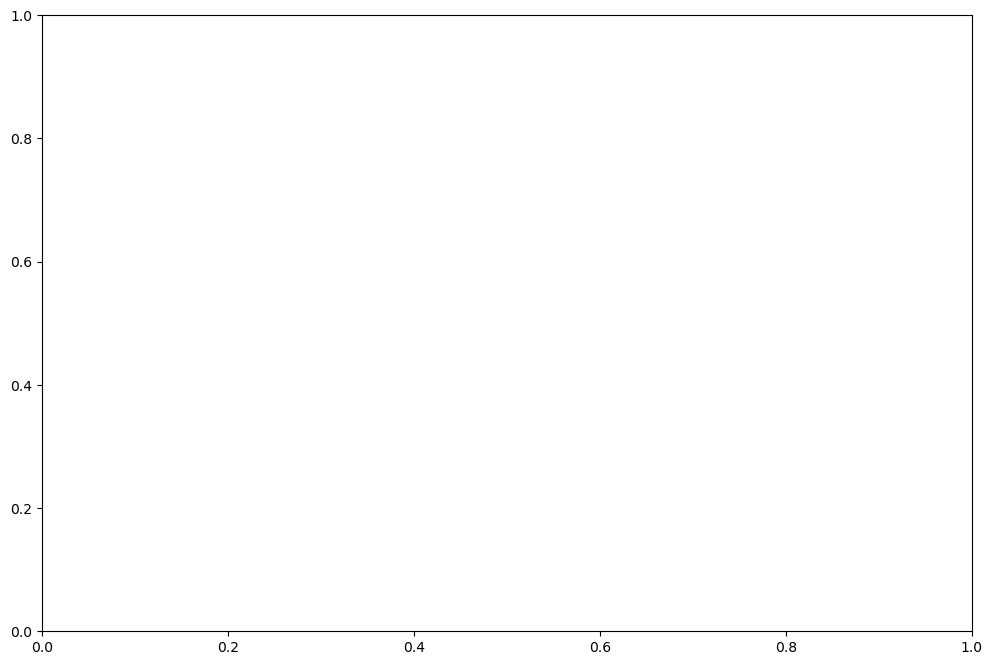

In [129]:
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL import Image
import urllib

value_colors = {
    'home': 'red',
    'away': 'blue',
    # Add more mappings as needed
}


shots = final_shot_data
shots['game_id'] = shots['game_id'].astype(int)
shots['period'] = shots['period'].astype(int)
first_period= shots.query('game_id == 2023020589 and period ==1')
#first_period
fig, ax = plt.subplots(figsize=(12, 8)) 

# Map the triCode values to colors
default_color = 'gray'  # Set a default color for NaN values
first_period['color'] = first_period['value'].fillna(default_color).map(value_colors)

#first_period

# Assuming shots DataFrame contains a 'team_logo' column and a 'value' column indicating home or away
home_shots = shots[shots['value'] == 'home']
away_shots = shots[shots['value'] == 'away']

# Convert 'team_logo' values to strings
home_shots['logo_link'] = home_shots['logo_link'].astype(str)
away_shots['logo_link'] = away_shots['logo_link'].astype(str)
# Assuming 'logo_link' contains URLs or file paths
shots['logo_link'] = shots['logo_link'].astype(str)

# Continue with the NHLRink creation
rink = NHLRink(
    home_logo={
        "feature_class": RinkImage,
        "image_path": home_shots['logo_link'],  # Use the home team logos
        "x": 55, "length": 50, "width": 42,
        "zorder": 15, "alpha": 0.5,
    },
    away_logo={
        "feature_class": RinkImage,
        "image_path": away_shots['logo_link'],  # Use the away team logos
        "x": -55, "length": 50, "width": 29,
        "zorder": 15, "alpha": 0.5,
    }
)



# Use the 'color' column for dot colors
rink.scatter("xCoord", "yCoord", s=100, c=first_period['color'], edgecolor="white", data=first_period, ax=ax)

plt.show()

In [81]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
shots

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  team_id  \
0            13       1        00:39                  left       506        6   
1            14       1        00:41                  left       505        6   
2            36       1        02:30                  left       506        5   
3            37       1        02:48                  left       506        5   
4            43       1        03:14                  left       506        6   
5            45       1        03:30                  left       506        5   
6            57       1        04:29                  left       506        5   
7            65       1        05:02                  left       506        5   
8            66       1        05:04                  left       505        5   
9            70       1        05:34                  left       508        5   
10           71       1        05:34                  left       506        5   
11           77       1        06:17                  left       505        5   
12           81       1        06:39                  left       505        6   
13           85       1        06:58                  left       508        6   
14           90       1        07:21                  left       505        5   
15           94       1        07:28                  left       507        5   
16          106       1        08:35                  left       506        5   
17          108       1        08:50                  left       507        5   
18          112       1        09:25                  left       507        6   
19          113       1        09:33                  left       506        6   
20          114       1        09:34                  left       507        6   
21          115       1        09:42                  left       508        5   
22          116       1        09:49                  left       506        6   
23          119       1        09:56                  left       506        6   
24          120       1        10:13                  left       506        6   
25          135       1        10:53                  left       508        5   
26          141       1        11:10                  left       506        5   
27          142       1        11:14                  left       506        5   
28          147       1        11:38                  left       506        5   
29          156       1        12:22                  left       506        6   
30          157       1        12:31                  left       508        6   
31          162       1        12:42                  left       506        5   
32          163       1        12:57                  left       508        6   
33          177       1        14:02                  left       506        6   
34          178       1        14:24                  left       507        5   
35          183       1        14:38                  left       508        5   
36          195       1        15:58                  left       505        5   
37          201       1        16:39                  left       506        6   
38          202       1        16:47                  left       508        5   
39          203       1        17:16                  left       508        5   
40          211       1        18:06                  left       506        5   
41          217       1        18:38                  left       508        6   
42          219       1        18:52                  left       507        5   
43          220       1        18:57                  left       507        5   
44          231       1        19:27                  left       507        5   
45          262       2        01:47                 right       506        5   
46          271       2        02:19                 right       506        5   
47          290       2        03:56                 right       507        5   
48          305       2        04:40 

In [12]:
from hockey_rink import NHLRink, RinkImage
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib
import requests
import os 
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint 
import pytz
import schedule
import time
from PIL import Image
from IPython.display import display
pd.options.mode.chained_assignment = None 
import re

goal_location_df = 'C:\\Users\\Karoline Sears\\Documents\\GitHub\\hockey-streamlit\\data\\goal_locations.csv'
goal_location_df= pd.read_csv(goal_location_df)
final_shot_data.head()

sortOrder  period timeInPeriod homeTeamDefendingSide  typeCode  team_id  \
0         13       1        00:39                  left       506        6   
1         14       1        00:41                  left       505        6   
2         36       1        02:30                  left       506        5   
3         37       1        02:48                  left       506        5   
4         43       1        03:14                  left       506        6   

   xCoord  yCoord   shotType  scoringPlayerId     game_id tri_code  \
0    46.0   -24.0      wrist              NaN  2023020589      BOS   
1    80.0     5.0      wrist        8473419.0  2023020589      BOS   
2   -83.0     8.0      wrist              NaN  2023020589      PIT   
3   -80.0     0.0     tip-in              NaN  2023020589      PIT   
4    66.0    -7.0  deflected              NaN  2023020589      BOS   

    team_name value                                          team_logo  
0      Boston  home  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...  
1      Boston  home  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...  
2  Pittsburgh  away  https://assets.nhle.com/logos/nhl/svg/PIT_ligh...  
3  Pittsburgh  away  https://assets.nhle.com/logos/nhl/svg/PIT_ligh...  
4      Boston  home  https://assets.nhle.com/logos/nhl/svg/BOS_ligh...

In [14]:
freddy_goals = goal_location_df.query('player_name =="Trent Frederic"')
freddy_goals

jersey_number  player_id     player_name position      team_name  \
3676           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3677           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3678           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3679           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3680           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3681           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3682           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3683           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3684           11.0  8479365.0  Trent Frederic        C  Boston Bruins   
3685           11.0  8479365.0  Trent Frederic        C  Boston Bruins   

      sortOrder  period  xCoord  yCoord     game_id  
3676         80       1    77.0    -1.0  2023020607  
3677        170       1    83.0   -10.0  2023020006  
3678        210       1    52.0    -2.0  2023020193  
3679        256       1    67.0    -5.0  2023020258  
3680        301       2   -93.0    -7.0  2023020607  
3681        307       2   -78.0    -2.0  2023020462  
3682        469       2   -76.0    -2.0  2023020258  
3683        567       3    82.0     4.0  2023020092  
3684        715       3   -75.0    10.0  2023020574  
3685        818       3    85.0     2.0  2023020364

In [ ]:
freddy_shots =final_shots_data.query('')

In [ ]:
ozone_shots = (
    freddy
    .assign(
        is_goal=shots.event_type == "GOAL",
        x=np.abs(shots.x),
        y=shots.y * np.sign(shots.x),
    )
)

fig, axs = plt.subplots(1, 3, figsize=(18, 8))

rink = NHLRink(rotation=270, net={"visible": False})

rink.contourf(
    "x", "y", "is_goal", data=ozone_shots, 
    nbins=8, levels=30, plot_range="ozone", cmap="bwr",
    ax=axs[0], draw_kw={"display_range": "ozone"},
)

rink.heatmap(
    "x", "y", "is_goal", data=ozone_shots, 
    binsize=5, fill_value=0, plot_xlim=(25, 89), cmap="magma", vmax=0.25,
    ax=axs[1], draw_kw={"display_range": "ozone"},
)

rink.hexbin(
    "x", "y", "is_goal", data=ozone_shots,
    gridsize=(14, 8), plot_range="ozone", alpha=0.85, vmax=0.25,
    ax=axs[2], draw_kw={"display_range": "ozone"},
)